In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms, models # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns # type: ignore
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Tensor Converting

We need to make sure that our final dimension is 3, 128, 128 as e is the first neuron and 128 is number of px the image has

In [2]:
train = pd.read_pickle('train_128.pkl')

pixel_data = np.array(train['pixels'].tolist())
labels = np.array(train['label'].tolist())

# Convert the pixel data to a tensor and ensure the right shape
X = torch.tensor(pixel_data, dtype=torch.float32)
X = X.permute(0, 3, 1, 2) # Convert tensor dimention from 128, 128, 3 into 3, 128, 128
y = torch.tensor(labels, dtype=torch.float32)

# Create a TensorDataset
dataset = TensorDataset(X, y)

print(X.shape, y.shape)

torch.Size([40000, 3, 128, 128]) torch.Size([40000])


In [3]:
test = pd.read_pickle('test_128.pkl')

test_pixel_data = np.array(test['pixels'].tolist())
test_labels = np.array(test['label'].tolist())

# Convert the pixel data to a tensor and ensure the right shape
test_X = torch.tensor(test_pixel_data, dtype=torch.float32)
test_X = test_X.permute(0, 3, 1, 2) 
test_y = torch.tensor(test_labels, dtype=torch.float32)

# Create a TensorDataset
test_dataset = TensorDataset(test_X, test_y)

print(test_X.shape, test_y.shape)

torch.Size([5000, 3, 128, 128]) torch.Size([5000])


Model Architecure

We decided to go with CNN model

In [4]:
# CNN Model Architecture
class CatDogCNN(nn.Module):
    def __init__(self, first_neuron):
        super(CatDogCNN, self).__init__()

        self.first_out_channels = first_neuron
        
        self.features = nn.Sequential(
            # First Convolutional Block
            nn.Conv2d(in_channels=3, out_channels=self.first_out_channels, kernel_size=3, padding=1),  # dimension [batch_size, out_channel, 128, `128`] -> padding = 1
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels),
            nn.MaxPool2d(2), # dimension [batch_size, out_channel, 64, 64]
            
            # Second Convolutional Block
            nn.Conv2d(in_channels=self.first_out_channels, out_channels=self.first_out_channels*2, kernel_size=3, padding=1), # dimension [batch_size, out_channel, 32, 32]
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels*2),
            nn.MaxPool2d(2), # dimension [batch_size, out_channel*2, 32, 32]
            
            # Third Convolutional Block
            nn.Conv2d(in_channels=self.first_out_channels*2, out_channels=self.first_out_channels*4, kernel_size=3, padding=1), # dimension [batch_size, out_channel, 16, 16]
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels*4),
            nn.MaxPool2d(2), # dimension [batch_size, out_channel*4, 16, 16]
        )
        
        # Calculate size of flattened features after the convolutional layers
        self.flatten_size = self.first_out_channels * 4 * (128 // (2**3)) * (128 // (2**3)) # out_channel * (128 // 2^amount_of_max_pool) * (128 // 2^amount_of_max_pool)
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.flatten_size, 256), # dimension [batch_size, 256]
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), # dimension [batch_size, 128]
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1), # dimension [batch_size, 1]
            nn.Sigmoid() # To get value from 0 to 1
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

# Training Functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            running_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [5]:
import matplotlib.pyplot as plt
from collections import defaultdict

class ModelTracker:
    def __init__(self, model_params):
        self.history = defaultdict(list)
        self.model_params = model_params
    
    def update(self, metrics):
        for key, value in metrics.items():
            self.history[key].append(value)
    
    def get_best_validation_metrics(self):
        val_accs = self.history['val_acc']
        best_acc = max(val_accs)
        best_epoch = val_accs.index(best_acc) + 1  # +1 because epochs start from 1
        return best_acc, best_epoch
    
    def plot_metrics(self):
        """Plot training and validation metrics with parameters."""
        # Create figure with custom layout
        fig = plt.figure(figsize=(20, 10))
        
        # Create grid spec for custom layout
        gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 1])
        
        # Loss subplot
        ax1 = fig.add_subplot(gs[0, 0])
        epochs = range(1, len(self.history['train_loss']) + 1)
        ax1.plot(epochs, self.history['train_loss'], 'b-', label='Training Loss', marker='o')
        ax1.plot(epochs, self.history['val_loss'], 'r-', label='Validation Loss', marker='o')
        ax1.set_title('Model Loss', fontsize=12, pad=10)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper right')
        ax1.grid(True, linestyle='--', alpha=0.7)
        
        # Accuracy subplot
        ax2 = fig.add_subplot(gs[1, 0])
        ax2.plot(epochs, self.history['train_acc'], 'b-', label='Training Accuracy', marker='o')
        ax2.plot(epochs, self.history['val_acc'], 'r-', label='Validation Accuracy', marker='o')
        ax2.set_title('Model Accuracy', fontsize=12, pad=10)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend(loc='lower right')
        ax2.grid(True, linestyle='--', alpha=0.7)
        
        # Parameters text box
        params_ax = fig.add_subplot(gs[:, 1])
        params_ax.axis('off')
        
        # Create parameter text
        params_text = "Model Parameters:\n" + "="*30 + "\n"
        for param, value in self.model_params.items():
            params_text += f"{param:<20}: {value}\n"
        
        # Add overfitting analysis
        overfitting_analysis = self.check_overfitting()
        params_text += "\nOverfitting Analysis:\n" + "="*30 + "\n"
        params_text += overfitting_analysis
        
        # Get best validation metrics
        best_val_acc, best_epoch = self.get_best_validation_metrics()
        
        # Add final metrics
        params_text += "\n\nFinal Metrics:\n" + "="*30 + "\n"
        params_text += f"Training Loss: {self.history['train_loss'][-1]:.4f}\n"
        params_text += f"Validation Loss: {self.history['val_loss'][-1]:.4f}\n"
        params_text += f"Training Accuracy: {self.history['train_acc'][-1]:.2f}%\n"
        params_text += f"Validation Accuracy: {self.history['val_acc'][-1]:.2f}%\n"
        params_text += f"\nBest Validation Accuracy: {best_val_acc:.2f}%\n"
        params_text += f"Best Validation Epoch: {best_epoch}"
        
        # Add text to figure
        params_ax.text(0, 0.95, params_text, transform=params_ax.transAxes,
                      fontsize=10, verticalalignment='top',
                      family='monospace', bbox=dict(facecolor='white', 
                                                  alpha=0.8,
                                                  edgecolor='gray',
                                                  boxstyle='round,pad=1'))
        
        # Add timestamp and title
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        fig.suptitle(f"Training Results - {timestamp}", fontsize=14, y=0.98)
        
        plt.tight_layout()
        plt.show()
        return fig
    
    def check_overfitting(self, threshold=5):
        """Check for signs of overfitting"""
        if len(self.history['train_acc']) < 2:
            return "Not enough epochs to determine overfitting"
        
        train_acc = self.history['train_acc'][-1]
        val_acc = self.history['val_acc'][-1]
        acc_diff = train_acc - val_acc
        
        val_loss_trend = self.history['val_loss'][-3:]  # Last 3 epochs
        
        analysis = []
        if acc_diff > threshold:
            analysis.append(f"Warning: Training accuracy exceeds\nvalidation accuracy by {acc_diff:.2f}%")
        
        if len(val_loss_trend) == 3 and all(val_loss_trend[i] > val_loss_trend[i-1] for i in range(1, len(val_loss_trend))):
            analysis.append("Warning: Validation loss is\nconsistently increasing")
            
        return "\n".join(analysis) if analysis else "No clear signs of overfitting detected"

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    # Define model parameters
    model_params = {
        "Batch Size": train_loader.batch_size,
        "Learning Rate": optimizer.param_groups[0]['lr'],
        "Epochs": num_epochs,
        "Criterion": criterion.__class__.__name__,
        "Optimizer": optimizer.__class__.__name__,
        "First Out Channels": model.first_out_channels,
        "Model Architecture": "CatDogCNN",
        "Device": device,
        "Total Parameters": sum(p.numel() for p in model.parameters()),
        "Trainable Parameters": sum(p.numel() for p in model.parameters() if p.requires_grad)
    }
    
    tracker = ModelTracker(model_params)
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation
        val_loss, val_acc, val_pred, val_labels = validate(model, val_loader, criterion, device)
        
        # Update metrics
        metrics = {
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        }
        tracker.update(metrics)
        
        # Print epoch results
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
        
    
    # Plot final results
    fig = tracker.plot_metrics()

    # Save the figure
    output_dir = "grid-search-results"
    os.makedirs(output_dir, exist_ok=True)

    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    file_path = os.path.join(output_dir, f"Training Results - {timestamp}.jpg")
    fig.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    return tracker

In [8]:
neuron = 32
model = CatDogCNN(neuron).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
NUM_EPOCHS = 20
BATCH_SIZE = 32


# DataLoader
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # Total Batch = 40000/32 = 1250
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # Total Batch = 5000/32 = 156.25 = 157


Epoch 1/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 164.57it/s]


Train Loss: 0.6298, Train Acc: 65.03%
Validation Loss: 0.5473, Validation Acc: 73.30%

Epoch 2/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 150.92it/s]


Train Loss: 0.5173, Train Acc: 74.70%
Validation Loss: 0.3709, Validation Acc: 83.70%

Epoch 3/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 162.32it/s]


Train Loss: 0.4330, Train Acc: 80.02%
Validation Loss: 0.3379, Validation Acc: 84.20%

Epoch 4/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 159.44it/s]


Train Loss: 0.3776, Train Acc: 82.87%
Validation Loss: 0.2052, Validation Acc: 91.42%

Epoch 5/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 163.71it/s]


Train Loss: 0.3306, Train Acc: 85.27%
Validation Loss: 0.1445, Validation Acc: 94.56%

Epoch 6/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 162.04it/s]


Train Loss: 0.2849, Train Acc: 87.78%
Validation Loss: 0.1599, Validation Acc: 93.56%

Epoch 7/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 150.20it/s]


Train Loss: 0.2501, Train Acc: 89.61%
Validation Loss: 0.1077, Validation Acc: 95.86%

Epoch 8/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 152.31it/s]


Train Loss: 0.2130, Train Acc: 91.03%
Validation Loss: 0.0571, Validation Acc: 98.38%

Epoch 9/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 156.86it/s]


Train Loss: 0.1842, Train Acc: 92.50%
Validation Loss: 0.0350, Validation Acc: 98.96%

Epoch 10/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 158.96it/s]


Train Loss: 0.1609, Train Acc: 93.71%
Validation Loss: 0.0290, Validation Acc: 99.08%

Epoch 11/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 156.74it/s]


Train Loss: 0.1391, Train Acc: 94.48%
Validation Loss: 0.0360, Validation Acc: 98.96%

Epoch 12/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 156.98it/s]


Train Loss: 0.1217, Train Acc: 95.31%
Validation Loss: 0.0203, Validation Acc: 99.50%

Epoch 13/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 160.11it/s]


Train Loss: 0.1083, Train Acc: 95.92%
Validation Loss: 0.0355, Validation Acc: 99.02%

Epoch 14/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 159.69it/s]


Train Loss: 0.1028, Train Acc: 96.17%
Validation Loss: 0.0139, Validation Acc: 99.72%

Epoch 15/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 161.22it/s]


Train Loss: 0.0877, Train Acc: 96.83%
Validation Loss: 0.0091, Validation Acc: 99.84%

Epoch 16/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 158.58it/s]


Train Loss: 0.0832, Train Acc: 96.94%
Validation Loss: 0.0169, Validation Acc: 99.52%

Epoch 17/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 159.06it/s]


Train Loss: 0.0824, Train Acc: 97.02%
Validation Loss: 0.0289, Validation Acc: 98.86%

Epoch 18/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 159.13it/s]


Train Loss: 0.0757, Train Acc: 97.31%
Validation Loss: 0.0160, Validation Acc: 99.72%

Epoch 19/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 157.05it/s]


Train Loss: 0.0654, Train Acc: 97.64%
Validation Loss: 0.0071, Validation Acc: 99.80%

Epoch 20/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 161.95it/s]


Train Loss: 0.0634, Train Acc: 97.78%
Validation Loss: 0.0047, Validation Acc: 99.88%


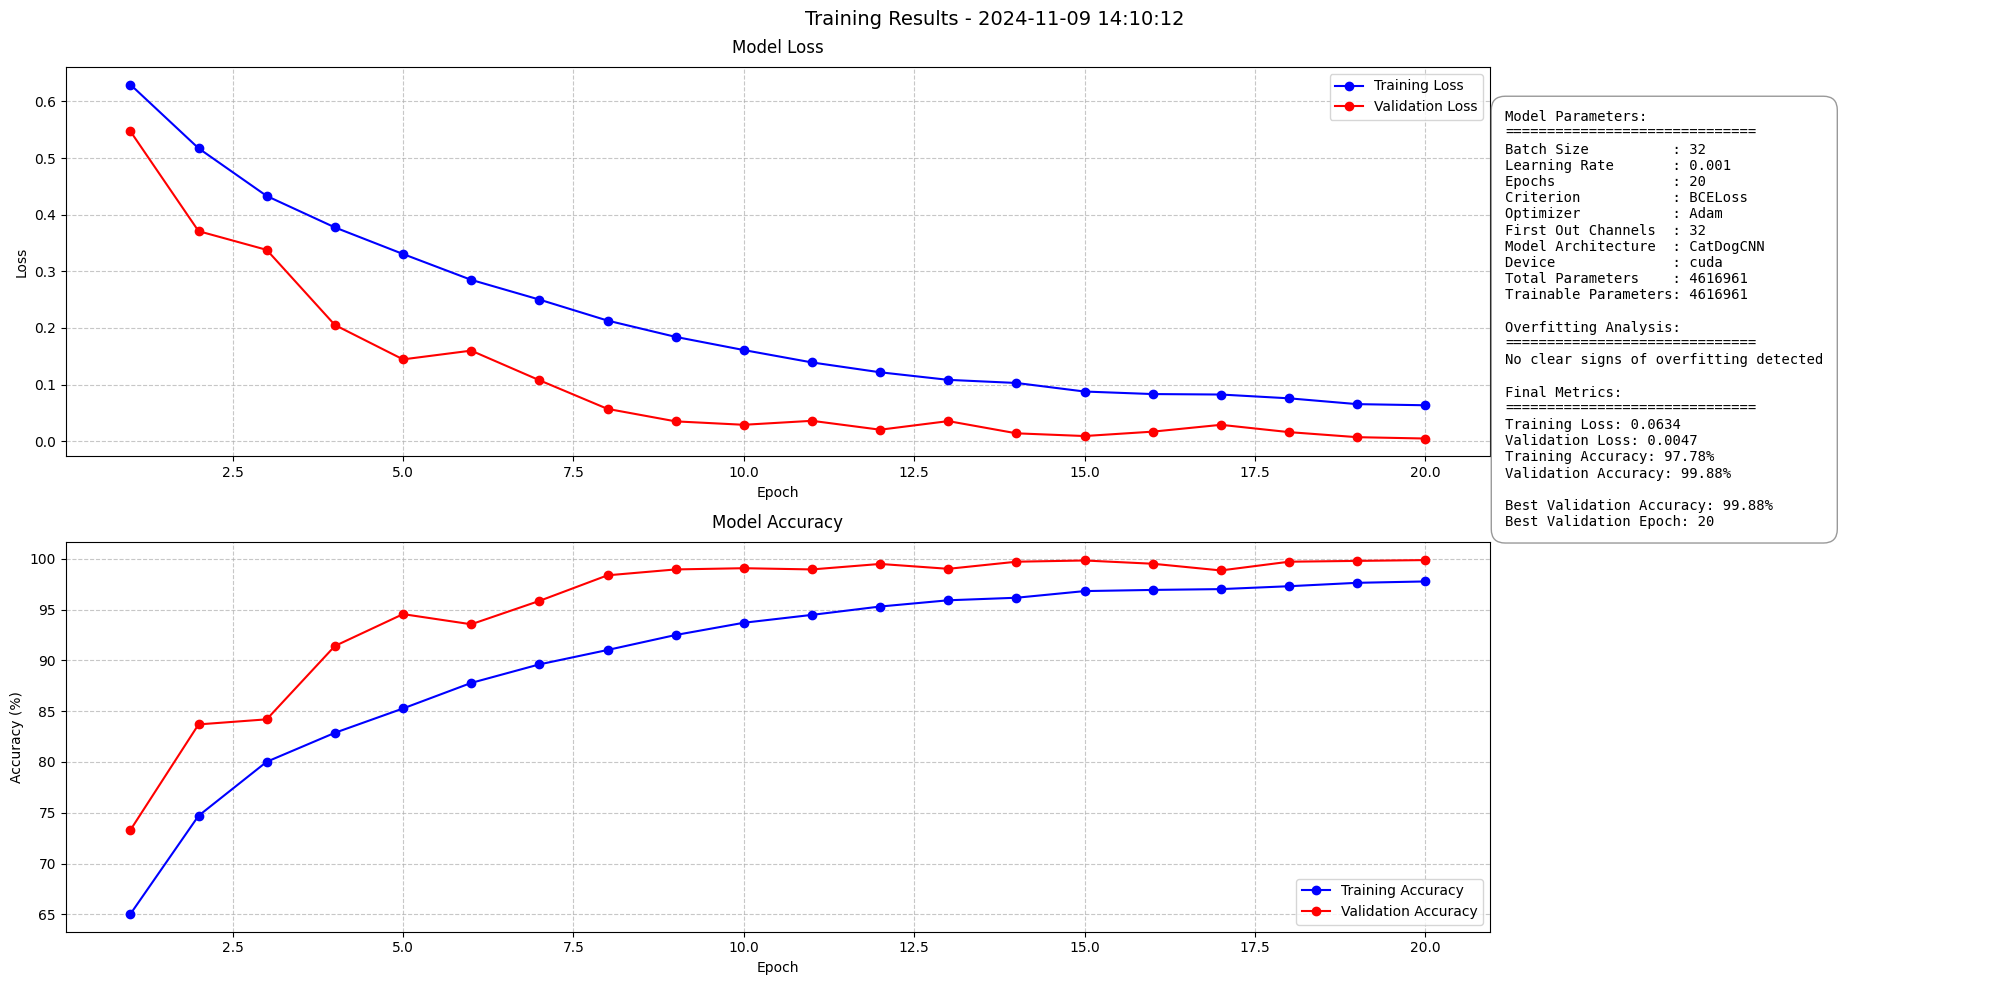

In [9]:
tracker = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=device
)

(Trial and Error with picture 64 x 64 px to save resource and training time)
Highest Val Acc : 89.54%  on epoch 9

Good Parameter:
1. Start from 128 output channel
2. epoch = 10
3. learning rate = 0.001
4. batch size = 32
5. BCELoss (for 1 output), crossEnthropy for 2 output, and optim Adam (We are using BCELoss) -> CrossEntropy sucks

*See training results folder for clearer plot diagram
Avoid: 
1. 0.1 learning rate is too high (highest acc = 50% wtf)
2. The same for 0.01 (highest acc = 50% wtf)
3. Learning rate 0.0001 is too small -> (take lr = 0.001)
4. Batch 4 training time is too slow (sadge) -> (highest acc = 86.14% epoch 9) -> Higher batch size tends the better but also need more computing power
5. Batch Size 16 (highest acc = 87.56%)
5. Batch 64 (highest acc = 87.94% epoch 6) -> (take bacth size = 32)
6. Output channel 16 (highest acc = 86.14%) -> (higher the better because more parameter of the model Total Parameter: 548353) -> (but also train slower as need more computing power)
7. Output channel 128 (highest acc = 89.54% epoch 9 Total Parameter = 5675265)
8. Output channel 256 (highest acc = 89.14% epoch 8 Total Parameter = 14299393) -> the acc decreases

Now we try to do hyperparameter tuning using grid search based on what we get already
we'll try to use these parameters
param_grid = {
    'learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [32, 64],
    'first_out_channels': [32, 64, 128, 256],
}

based on this, we can take these as the best params so far
{'learning_rate': 0.001, 'batch_size': 32, 'first_out_channels': 128}
88.68%

Now, let's try to change the model architecture and also cross validation and optimaziation function to see if we can get better accuracy.

We'll keep using Binary Cross Entrophy loss as it's better for binary classification, hence we will just use our final output channel to be 1

Trial: (for this we will use 15 epoch and 32 batch and 32 first output layer to spit testing) -> Best Acc : 89.98% epoch 12
1. Add 1 more cnn and relu and drop out layer (acc gets better with 0.3 prob dro out) -> take this
2. Add 2 more identical layer (acc decreases)
3. Changing Loss Function to MSELoss (acc actualy increases but need more epoch -- nevermind)
4. Changing optimaziation function to SGD (lr = 0.001, momentum = 0.9 -. not good)


Conclusion:
1. Try to use Adam Optimaziation Function
2. Use 32 batch size
3. learning rate 0.001
4. number of first neuron is either 32, 64, 128 (trial and error with grid search)

Training with neurons: 32, batch_size: 32, learning_rate: 0.005

Epoch 1/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 182.68it/s]


Train Loss: 0.6217, Train Acc: 64.51%
Validation Loss: 0.5231, Validation Acc: 73.50%

Epoch 2/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 181.29it/s]


Train Loss: 0.5473, Train Acc: 71.64%
Validation Loss: 0.4198, Validation Acc: 82.74%

Epoch 3/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 182.00it/s]


Train Loss: 0.4854, Train Acc: 76.12%
Validation Loss: 0.3485, Validation Acc: 84.48%

Epoch 4/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 184.41it/s]


Train Loss: 0.4264, Train Acc: 79.91%
Validation Loss: 0.2782, Validation Acc: 88.46%

Epoch 5/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 178.78it/s]


Train Loss: 0.3769, Train Acc: 82.71%
Validation Loss: 0.2135, Validation Acc: 92.84%

Epoch 6/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 177.06it/s]


Train Loss: 0.3201, Train Acc: 85.81%
Validation Loss: 0.1724, Validation Acc: 93.64%

Epoch 7/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 184.38it/s]


Train Loss: 0.2694, Train Acc: 88.29%
Validation Loss: 0.1044, Validation Acc: 97.28%

Epoch 8/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 181.20it/s]


Train Loss: 0.2264, Train Acc: 90.46%
Validation Loss: 0.0571, Validation Acc: 98.66%

Epoch 9/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 182.96it/s]


Train Loss: 0.1815, Train Acc: 92.37%
Validation Loss: 0.0503, Validation Acc: 98.46%

Epoch 10/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 100.25it/s]


Train Loss: 0.1533, Train Acc: 93.75%
Validation Loss: 0.0405, Validation Acc: 98.82%

Epoch 11/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 190.47it/s]


Train Loss: 0.1302, Train Acc: 94.86%
Validation Loss: 0.0278, Validation Acc: 99.50%

Epoch 12/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 177.14it/s]


Train Loss: 0.1099, Train Acc: 95.77%
Validation Loss: 0.0230, Validation Acc: 99.54%

Epoch 13/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 180.75it/s]


Train Loss: 0.0975, Train Acc: 96.38%
Validation Loss: 0.0158, Validation Acc: 99.82%

Epoch 14/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 180.88it/s]


Train Loss: 0.0853, Train Acc: 96.79%
Validation Loss: 0.0203, Validation Acc: 99.64%

Epoch 15/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 179.97it/s]


Train Loss: 0.0739, Train Acc: 97.26%
Validation Loss: 0.0115, Validation Acc: 99.90%

Epoch 16/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 179.49it/s]


Train Loss: 0.0681, Train Acc: 97.38%
Validation Loss: 0.0081, Validation Acc: 99.82%

Epoch 17/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 178.72it/s]


Train Loss: 0.0584, Train Acc: 97.98%
Validation Loss: 0.0056, Validation Acc: 99.96%

Epoch 18/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 181.67it/s]


Train Loss: 0.0556, Train Acc: 97.97%
Validation Loss: 0.0216, Validation Acc: 99.12%

Epoch 19/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 175.02it/s]


Train Loss: 0.0483, Train Acc: 98.25%
Validation Loss: 0.0034, Validation Acc: 99.94%

Epoch 20/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 178.34it/s]


Train Loss: 0.0458, Train Acc: 98.40%
Validation Loss: 0.0046, Validation Acc: 99.92%


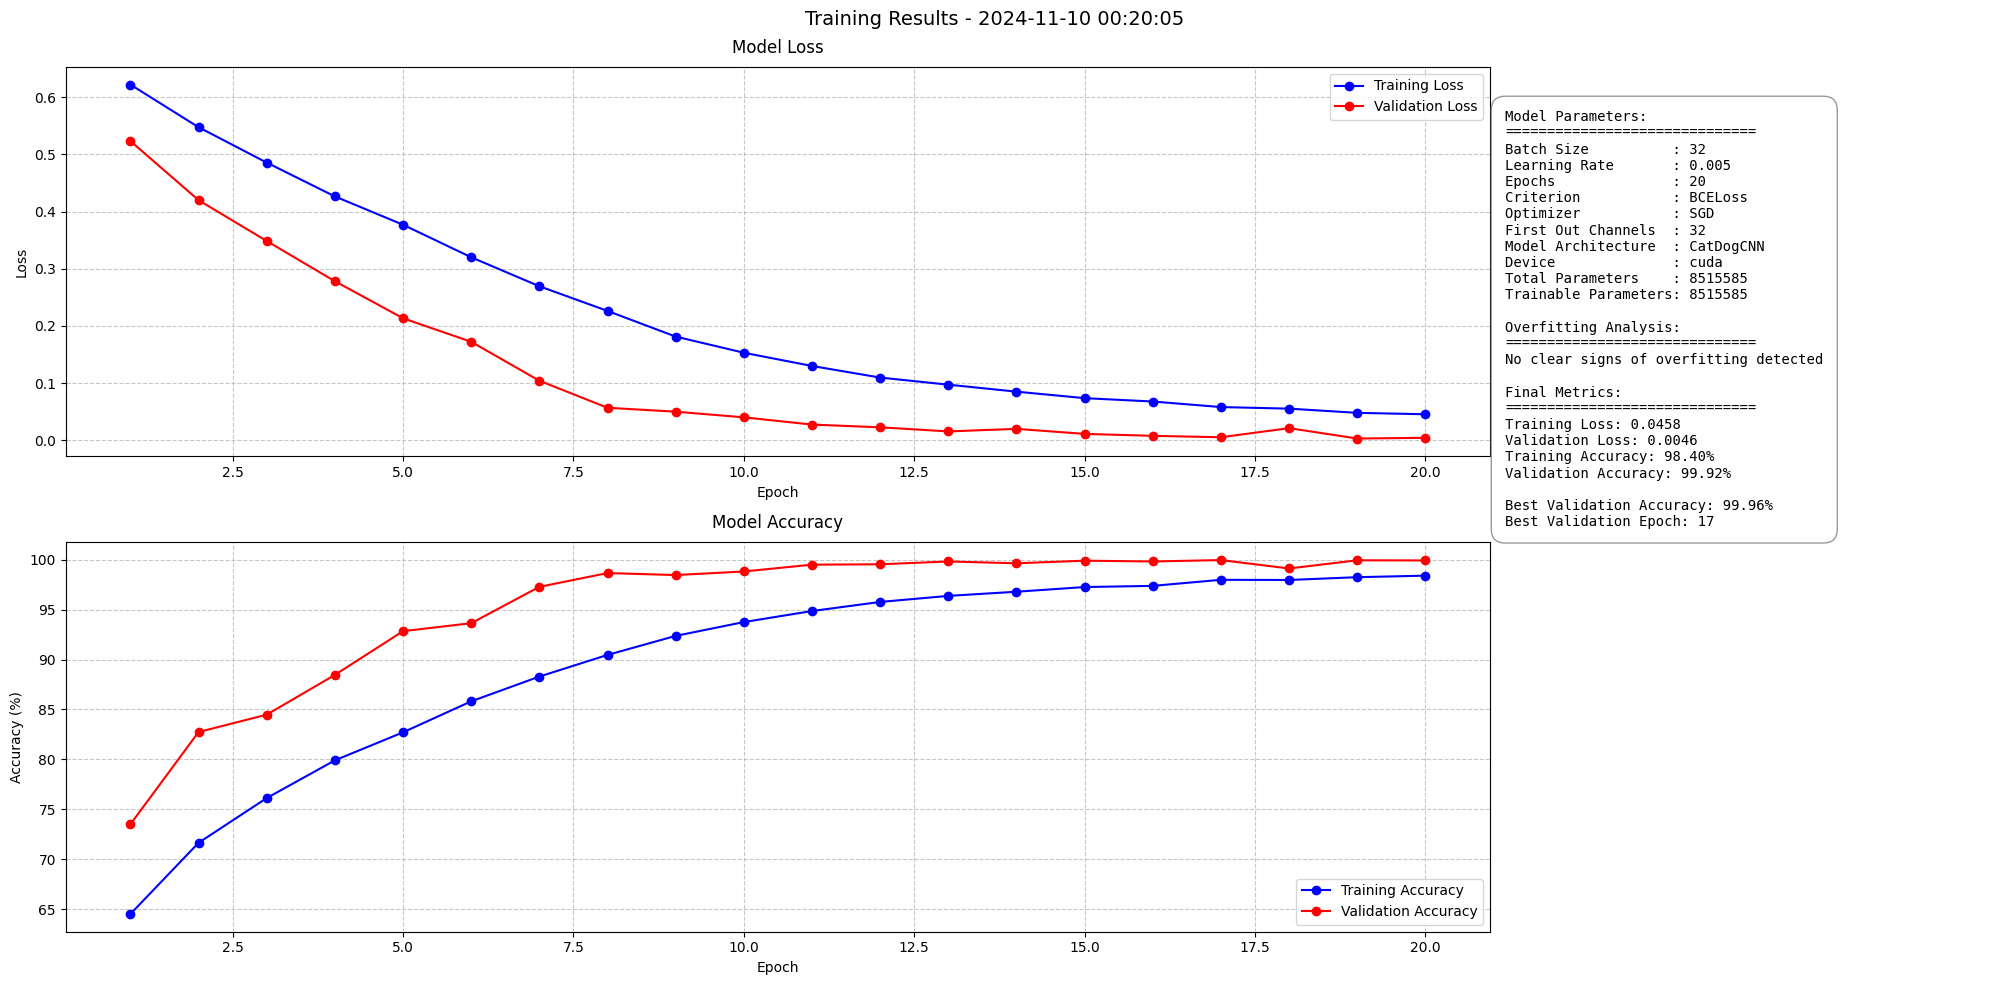

Training with neurons: 32, batch_size: 32, learning_rate: 0.001

Epoch 1/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 177.58it/s]


Train Loss: 0.6191, Train Acc: 64.56%
Validation Loss: 0.5134, Validation Acc: 73.82%

Epoch 2/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 181.55it/s]


Train Loss: 0.5392, Train Acc: 72.15%
Validation Loss: 0.4231, Validation Acc: 80.16%

Epoch 3/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 180.46it/s]


Train Loss: 0.4873, Train Acc: 76.03%
Validation Loss: 0.3561, Validation Acc: 84.46%

Epoch 4/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 184.00it/s]


Train Loss: 0.4407, Train Acc: 78.95%
Validation Loss: 0.2885, Validation Acc: 88.56%

Epoch 5/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 172.51it/s]


Train Loss: 0.3956, Train Acc: 81.73%
Validation Loss: 0.2681, Validation Acc: 88.74%

Epoch 6/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 98.24it/s] 


Train Loss: 0.3498, Train Acc: 84.40%
Validation Loss: 0.1956, Validation Acc: 92.92%

Epoch 7/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 183.27it/s]


Train Loss: 0.3024, Train Acc: 86.80%
Validation Loss: 0.1413, Validation Acc: 94.78%

Epoch 8/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 179.66it/s]


Train Loss: 0.2583, Train Acc: 88.96%
Validation Loss: 0.1366, Validation Acc: 95.00%

Epoch 9/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 178.77it/s]


Train Loss: 0.2180, Train Acc: 90.84%
Validation Loss: 0.0609, Validation Acc: 98.40%

Epoch 10/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 177.12it/s]


Train Loss: 0.1862, Train Acc: 92.39%
Validation Loss: 0.0592, Validation Acc: 98.46%

Epoch 11/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 178.30it/s]


Train Loss: 0.1543, Train Acc: 93.87%
Validation Loss: 0.0267, Validation Acc: 99.48%

Epoch 12/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 182.43it/s]


Train Loss: 0.1297, Train Acc: 95.01%
Validation Loss: 0.0757, Validation Acc: 97.00%

Epoch 13/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 180.12it/s]


Train Loss: 0.1088, Train Acc: 95.86%
Validation Loss: 0.0472, Validation Acc: 98.36%

Epoch 14/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 184.94it/s]


Train Loss: 0.1055, Train Acc: 95.94%
Validation Loss: 0.0153, Validation Acc: 99.58%

Epoch 15/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 182.64it/s]


Train Loss: 0.0856, Train Acc: 96.80%
Validation Loss: 0.0104, Validation Acc: 99.76%

Epoch 16/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 188.14it/s]


Train Loss: 0.0759, Train Acc: 97.19%
Validation Loss: 0.0084, Validation Acc: 99.80%

Epoch 17/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 180.41it/s]


Train Loss: 0.0658, Train Acc: 97.55%
Validation Loss: 0.0073, Validation Acc: 99.88%

Epoch 18/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 174.12it/s]


Train Loss: 0.0609, Train Acc: 97.79%
Validation Loss: 0.0039, Validation Acc: 99.94%

Epoch 19/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 179.38it/s]


Train Loss: 0.0530, Train Acc: 98.17%
Validation Loss: 0.0066, Validation Acc: 99.86%

Epoch 20/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 179.42it/s]


Train Loss: 0.0547, Train Acc: 97.94%
Validation Loss: 0.0047, Validation Acc: 99.92%


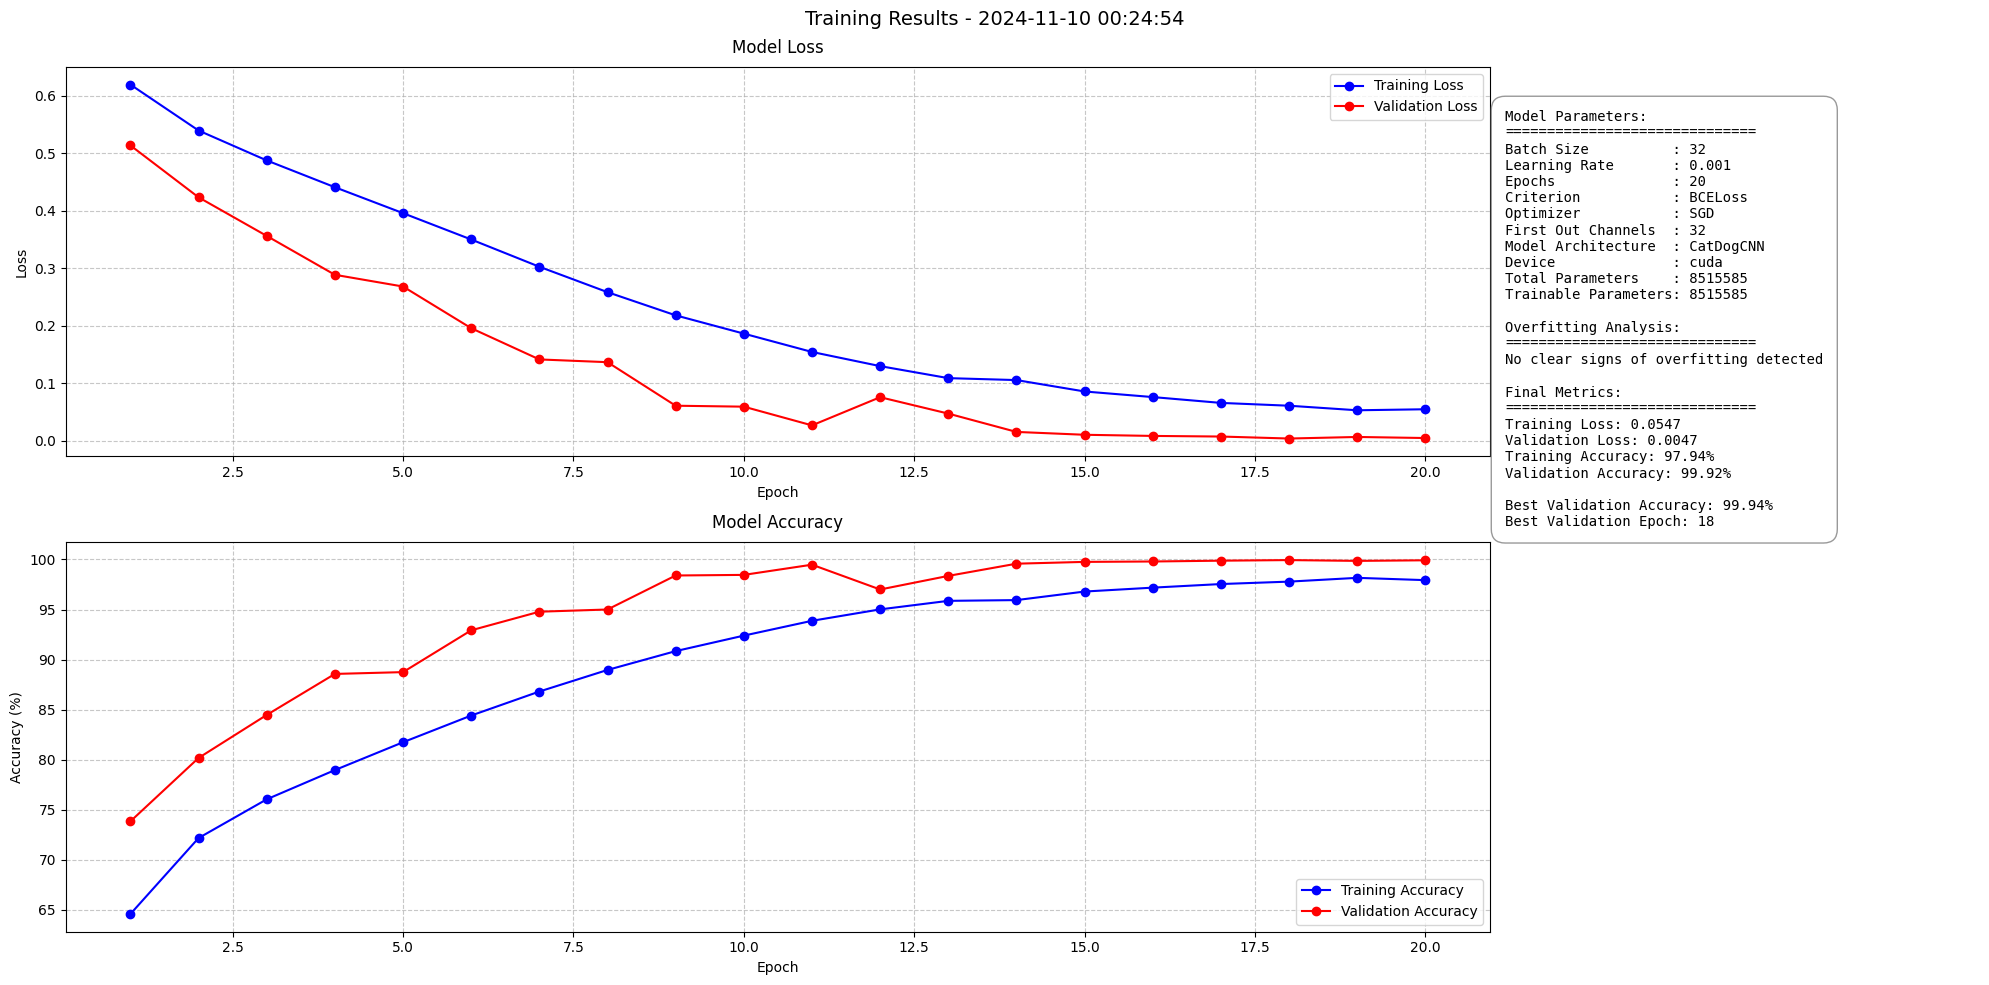

Training with neurons: 32, batch_size: 32, learning_rate: 0.0005

Epoch 1/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 181.80it/s]


Train Loss: 0.6229, Train Acc: 63.98%
Validation Loss: 0.5232, Validation Acc: 73.20%

Epoch 2/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 178.74it/s]


Train Loss: 0.5564, Train Acc: 70.75%
Validation Loss: 0.4670, Validation Acc: 77.64%

Epoch 3/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 182.50it/s]


Train Loss: 0.5120, Train Acc: 74.04%
Validation Loss: 0.3878, Validation Acc: 83.50%

Epoch 4/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 181.03it/s]


Train Loss: 0.4742, Train Acc: 76.81%
Validation Loss: 0.3584, Validation Acc: 83.90%

Epoch 5/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 175.97it/s]


Train Loss: 0.4400, Train Acc: 78.94%
Validation Loss: 0.3040, Validation Acc: 87.00%

Epoch 6/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 174.57it/s]


Train Loss: 0.3966, Train Acc: 81.68%
Validation Loss: 0.2629, Validation Acc: 89.96%

Epoch 7/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 177.13it/s]


Train Loss: 0.3585, Train Acc: 83.94%
Validation Loss: 0.2145, Validation Acc: 91.52%

Epoch 8/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 185.22it/s]


Train Loss: 0.3178, Train Acc: 86.03%
Validation Loss: 0.1658, Validation Acc: 94.32%

Epoch 9/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 161.59it/s]


Train Loss: 0.2773, Train Acc: 87.96%
Validation Loss: 0.1318, Validation Acc: 95.42%

Epoch 10/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 181.83it/s]


Train Loss: 0.2341, Train Acc: 90.26%
Validation Loss: 0.0728, Validation Acc: 97.98%

Epoch 11/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 179.64it/s]


Train Loss: 0.2020, Train Acc: 91.62%
Validation Loss: 0.0638, Validation Acc: 98.54%

Epoch 12/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 189.90it/s]


Train Loss: 0.1709, Train Acc: 93.22%
Validation Loss: 0.0404, Validation Acc: 98.96%

Epoch 13/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 173.86it/s]


Train Loss: 0.1431, Train Acc: 94.41%
Validation Loss: 0.0301, Validation Acc: 99.34%

Epoch 14/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 179.85it/s]


Train Loss: 0.1241, Train Acc: 95.19%
Validation Loss: 0.0173, Validation Acc: 99.64%

Epoch 15/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 179.24it/s]


Train Loss: 0.1051, Train Acc: 96.06%
Validation Loss: 0.0189, Validation Acc: 99.60%

Epoch 16/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 172.48it/s]


Train Loss: 0.0935, Train Acc: 96.60%
Validation Loss: 0.0128, Validation Acc: 99.80%

Epoch 17/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 188.24it/s]


Train Loss: 0.0800, Train Acc: 96.99%
Validation Loss: 0.0101, Validation Acc: 99.80%

Epoch 18/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 174.04it/s]


Train Loss: 0.0762, Train Acc: 97.14%
Validation Loss: 0.0105, Validation Acc: 99.86%

Epoch 19/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 177.25it/s]


Train Loss: 0.0673, Train Acc: 97.60%
Validation Loss: 0.0065, Validation Acc: 99.86%

Epoch 20/20


Validation: 100%|██████████| 157/157 [00:00<00:00, 180.60it/s]


Train Loss: 0.0612, Train Acc: 97.89%
Validation Loss: 0.0078, Validation Acc: 99.88%


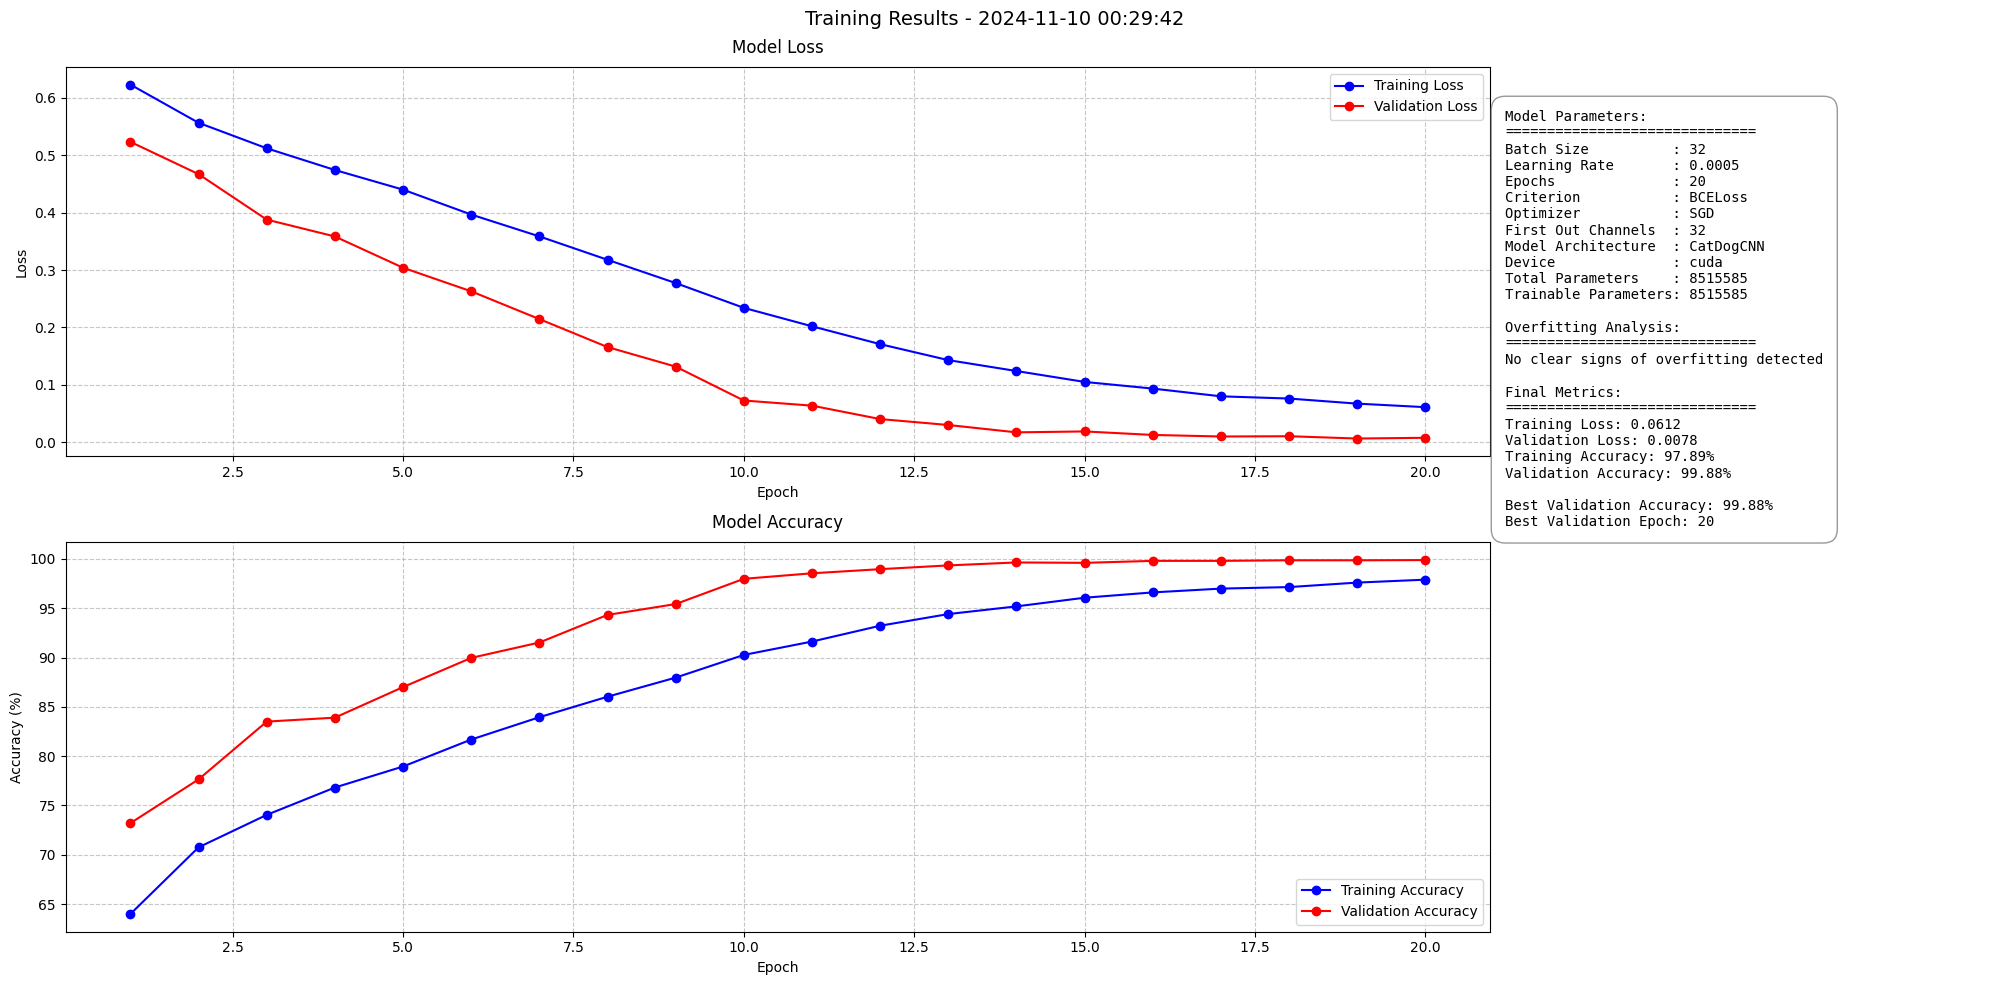

Training with neurons: 32, batch_size: 64, learning_rate: 0.005

Epoch 1/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 93.66it/s] 


Train Loss: 0.6121, Train Acc: 65.67%
Validation Loss: 0.5259, Validation Acc: 74.00%

Epoch 2/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 90.07it/s] 


Train Loss: 0.5425, Train Acc: 72.01%
Validation Loss: 0.4651, Validation Acc: 78.20%

Epoch 3/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 93.38it/s] 


Train Loss: 0.4865, Train Acc: 76.12%
Validation Loss: 0.3616, Validation Acc: 83.84%

Epoch 4/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.81it/s] 


Train Loss: 0.4359, Train Acc: 79.20%
Validation Loss: 0.3464, Validation Acc: 83.82%

Epoch 5/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.50it/s] 


Train Loss: 0.3806, Train Acc: 82.47%
Validation Loss: 0.2707, Validation Acc: 88.64%

Epoch 6/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.83it/s] 


Train Loss: 0.3320, Train Acc: 85.13%
Validation Loss: 0.3256, Validation Acc: 87.74%

Epoch 7/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 44.99it/s] 


Train Loss: 0.2778, Train Acc: 87.88%
Validation Loss: 0.1008, Validation Acc: 97.24%

Epoch 8/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 93.51it/s] 


Train Loss: 0.2313, Train Acc: 90.16%
Validation Loss: 0.0898, Validation Acc: 97.36%

Epoch 9/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.16it/s] 


Train Loss: 0.1898, Train Acc: 92.14%
Validation Loss: 0.1519, Validation Acc: 93.88%

Epoch 10/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 89.98it/s] 


Train Loss: 0.1605, Train Acc: 93.46%
Validation Loss: 0.0641, Validation Acc: 98.08%

Epoch 11/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 90.65it/s] 


Train Loss: 0.1351, Train Acc: 94.85%
Validation Loss: 0.0404, Validation Acc: 98.86%

Epoch 12/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.73it/s] 


Train Loss: 0.1186, Train Acc: 95.31%
Validation Loss: 0.0359, Validation Acc: 99.00%

Epoch 13/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.43it/s] 


Train Loss: 0.0938, Train Acc: 96.40%
Validation Loss: 0.0182, Validation Acc: 99.60%

Epoch 14/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.11it/s] 


Train Loss: 0.0842, Train Acc: 96.86%
Validation Loss: 0.0143, Validation Acc: 99.68%

Epoch 15/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.15it/s] 


Train Loss: 0.0713, Train Acc: 97.36%
Validation Loss: 0.0081, Validation Acc: 99.80%

Epoch 16/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.69it/s] 


Train Loss: 0.0639, Train Acc: 97.64%
Validation Loss: 0.0074, Validation Acc: 99.92%

Epoch 17/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.29it/s] 


Train Loss: 0.0568, Train Acc: 97.92%
Validation Loss: 0.0275, Validation Acc: 99.08%

Epoch 18/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.67it/s] 


Train Loss: 0.0530, Train Acc: 98.07%
Validation Loss: 0.0106, Validation Acc: 99.94%

Epoch 19/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.56it/s] 


Train Loss: 0.0429, Train Acc: 98.43%
Validation Loss: 0.0071, Validation Acc: 99.86%

Epoch 20/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.54it/s] 


Train Loss: 0.0477, Train Acc: 98.40%
Validation Loss: 0.0106, Validation Acc: 99.92%


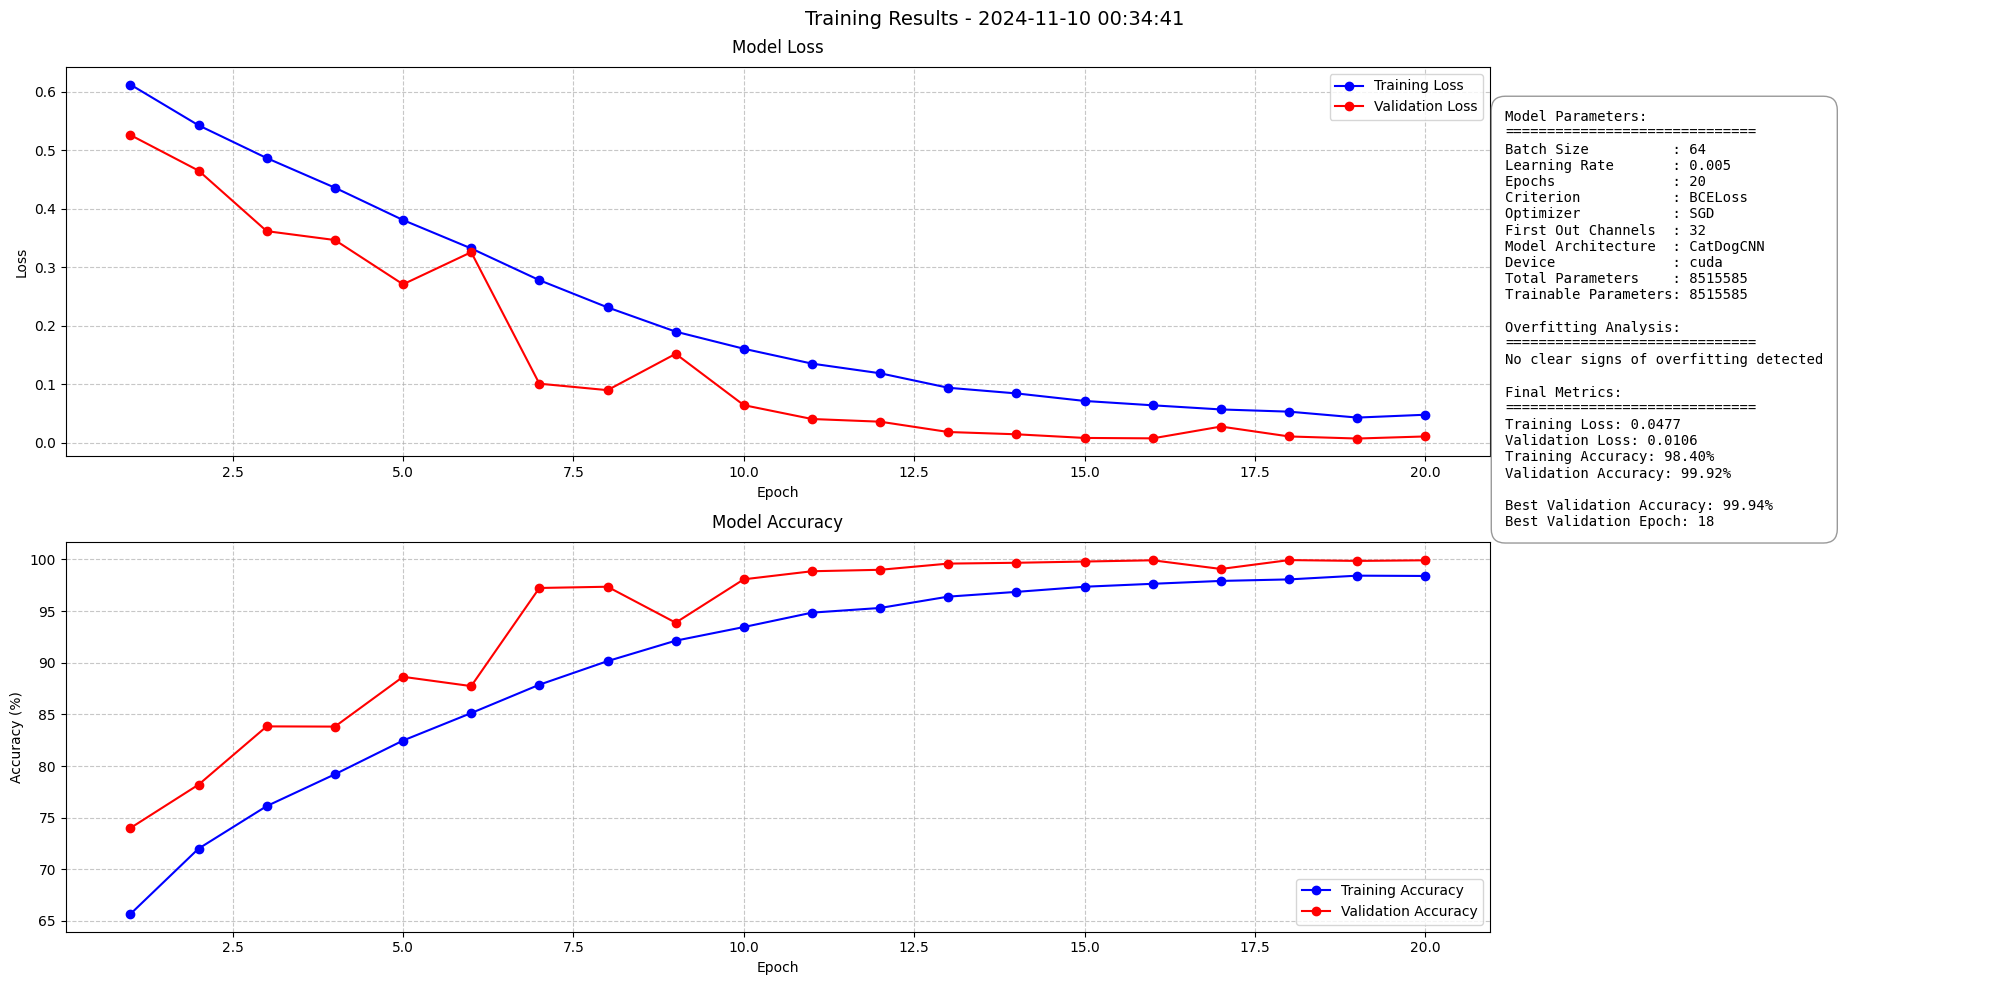

Training with neurons: 32, batch_size: 64, learning_rate: 0.001

Epoch 1/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.21it/s] 


Train Loss: 0.6385, Train Acc: 62.09%
Validation Loss: 0.5284, Validation Acc: 73.20%

Epoch 2/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.22it/s] 


Train Loss: 0.5667, Train Acc: 69.57%
Validation Loss: 0.4694, Validation Acc: 77.38%

Epoch 3/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.45it/s] 


Train Loss: 0.5145, Train Acc: 73.89%
Validation Loss: 0.4004, Validation Acc: 82.18%

Epoch 4/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.99it/s] 


Train Loss: 0.4703, Train Acc: 77.19%
Validation Loss: 0.3468, Validation Acc: 85.14%

Epoch 5/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.77it/s] 


Train Loss: 0.4265, Train Acc: 79.84%
Validation Loss: 0.3257, Validation Acc: 85.62%

Epoch 6/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.28it/s] 


Train Loss: 0.3936, Train Acc: 81.78%
Validation Loss: 0.3327, Validation Acc: 84.94%

Epoch 7/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 90.96it/s] 


Train Loss: 0.3476, Train Acc: 84.42%
Validation Loss: 0.2554, Validation Acc: 89.56%

Epoch 8/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 88.64it/s] 


Train Loss: 0.3053, Train Acc: 86.41%
Validation Loss: 0.1431, Validation Acc: 94.66%

Epoch 9/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.95it/s] 


Train Loss: 0.2591, Train Acc: 89.03%
Validation Loss: 0.1261, Validation Acc: 96.26%

Epoch 10/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.52it/s] 


Train Loss: 0.2202, Train Acc: 90.97%
Validation Loss: 0.0936, Validation Acc: 96.92%

Epoch 11/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.41it/s] 


Train Loss: 0.1860, Train Acc: 92.41%
Validation Loss: 0.1080, Validation Acc: 95.56%

Epoch 12/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.77it/s] 


Train Loss: 0.1540, Train Acc: 93.97%
Validation Loss: 0.0336, Validation Acc: 99.42%

Epoch 13/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 93.40it/s] 


Train Loss: 0.1326, Train Acc: 94.95%
Validation Loss: 0.0406, Validation Acc: 98.76%

Epoch 14/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.60it/s] 


Train Loss: 0.1135, Train Acc: 95.72%
Validation Loss: 0.0860, Validation Acc: 96.64%

Epoch 15/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.98it/s] 


Train Loss: 0.1052, Train Acc: 95.97%
Validation Loss: 0.0141, Validation Acc: 99.66%

Epoch 16/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.89it/s] 


Train Loss: 0.0866, Train Acc: 96.75%
Validation Loss: 0.0204, Validation Acc: 99.42%

Epoch 17/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 43.79it/s]


Train Loss: 0.0783, Train Acc: 97.14%
Validation Loss: 0.0183, Validation Acc: 99.44%

Epoch 18/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 90.54it/s] 


Train Loss: 0.0681, Train Acc: 97.56%
Validation Loss: 0.0087, Validation Acc: 99.78%

Epoch 19/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.04it/s] 


Train Loss: 0.0629, Train Acc: 97.77%
Validation Loss: 0.0147, Validation Acc: 99.70%

Epoch 20/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.27it/s] 


Train Loss: 0.0608, Train Acc: 97.83%
Validation Loss: 0.0090, Validation Acc: 99.84%


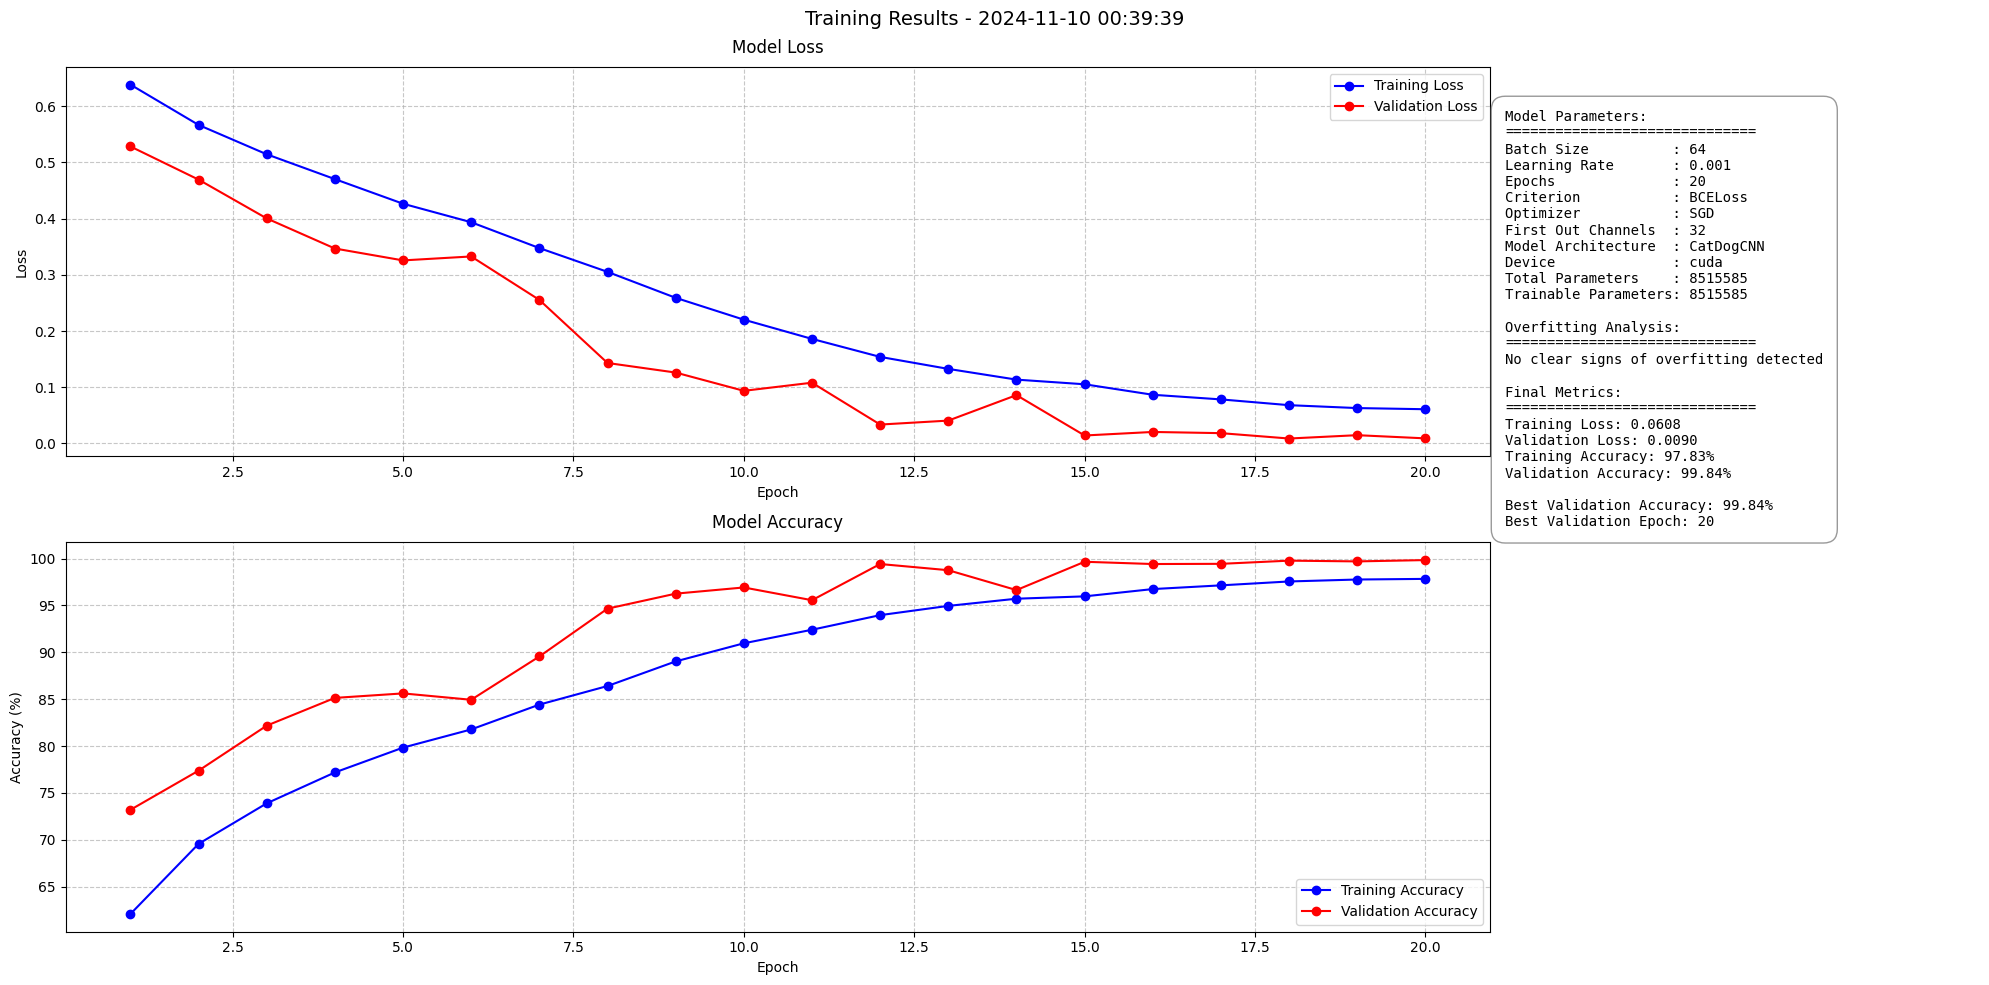

Training with neurons: 32, batch_size: 64, learning_rate: 0.0005

Epoch 1/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.07it/s] 


Train Loss: 0.6448, Train Acc: 62.02%
Validation Loss: 0.5459, Validation Acc: 72.38%

Epoch 2/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.20it/s] 


Train Loss: 0.5752, Train Acc: 68.94%
Validation Loss: 0.4619, Validation Acc: 78.44%

Epoch 3/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.53it/s] 


Train Loss: 0.5346, Train Acc: 72.41%
Validation Loss: 0.4311, Validation Acc: 80.40%

Epoch 4/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.43it/s] 


Train Loss: 0.4968, Train Acc: 75.45%
Validation Loss: 0.3763, Validation Acc: 83.32%

Epoch 5/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.01it/s] 


Train Loss: 0.4588, Train Acc: 77.98%
Validation Loss: 0.3283, Validation Acc: 85.88%

Epoch 6/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.09it/s] 


Train Loss: 0.4275, Train Acc: 80.12%
Validation Loss: 0.2904, Validation Acc: 88.72%

Epoch 7/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.18it/s] 


Train Loss: 0.3919, Train Acc: 82.13%
Validation Loss: 0.2946, Validation Acc: 87.46%

Epoch 8/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.15it/s] 


Train Loss: 0.3546, Train Acc: 84.27%
Validation Loss: 0.2264, Validation Acc: 91.04%

Epoch 9/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.81it/s] 


Train Loss: 0.3156, Train Acc: 86.38%
Validation Loss: 0.1742, Validation Acc: 94.04%

Epoch 10/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.36it/s] 


Train Loss: 0.2824, Train Acc: 88.12%
Validation Loss: 0.1622, Validation Acc: 93.82%

Epoch 11/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.89it/s] 


Train Loss: 0.2497, Train Acc: 89.43%
Validation Loss: 0.1264, Validation Acc: 96.34%

Epoch 12/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.83it/s] 


Train Loss: 0.2137, Train Acc: 91.48%
Validation Loss: 0.0854, Validation Acc: 97.10%

Epoch 13/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.28it/s] 


Train Loss: 0.1815, Train Acc: 92.78%
Validation Loss: 0.0821, Validation Acc: 98.40%

Epoch 14/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.40it/s] 


Train Loss: 0.1611, Train Acc: 93.77%
Validation Loss: 0.0503, Validation Acc: 98.92%

Epoch 15/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.45it/s] 


Train Loss: 0.1359, Train Acc: 94.81%
Validation Loss: 0.0429, Validation Acc: 98.96%

Epoch 16/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.92it/s] 


Train Loss: 0.1213, Train Acc: 95.41%
Validation Loss: 0.0519, Validation Acc: 98.50%

Epoch 17/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 43.96it/s]


Train Loss: 0.1026, Train Acc: 96.20%
Validation Loss: 0.0315, Validation Acc: 99.60%

Epoch 18/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.22it/s] 


Train Loss: 0.0937, Train Acc: 96.58%
Validation Loss: 0.0291, Validation Acc: 99.46%

Epoch 19/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.70it/s] 


Train Loss: 0.0872, Train Acc: 96.94%
Validation Loss: 0.0173, Validation Acc: 99.70%

Epoch 20/20


Validation: 100%|██████████| 79/79 [00:00<00:00, 91.40it/s] 


Train Loss: 0.0765, Train Acc: 97.22%
Validation Loss: 0.0151, Validation Acc: 99.74%


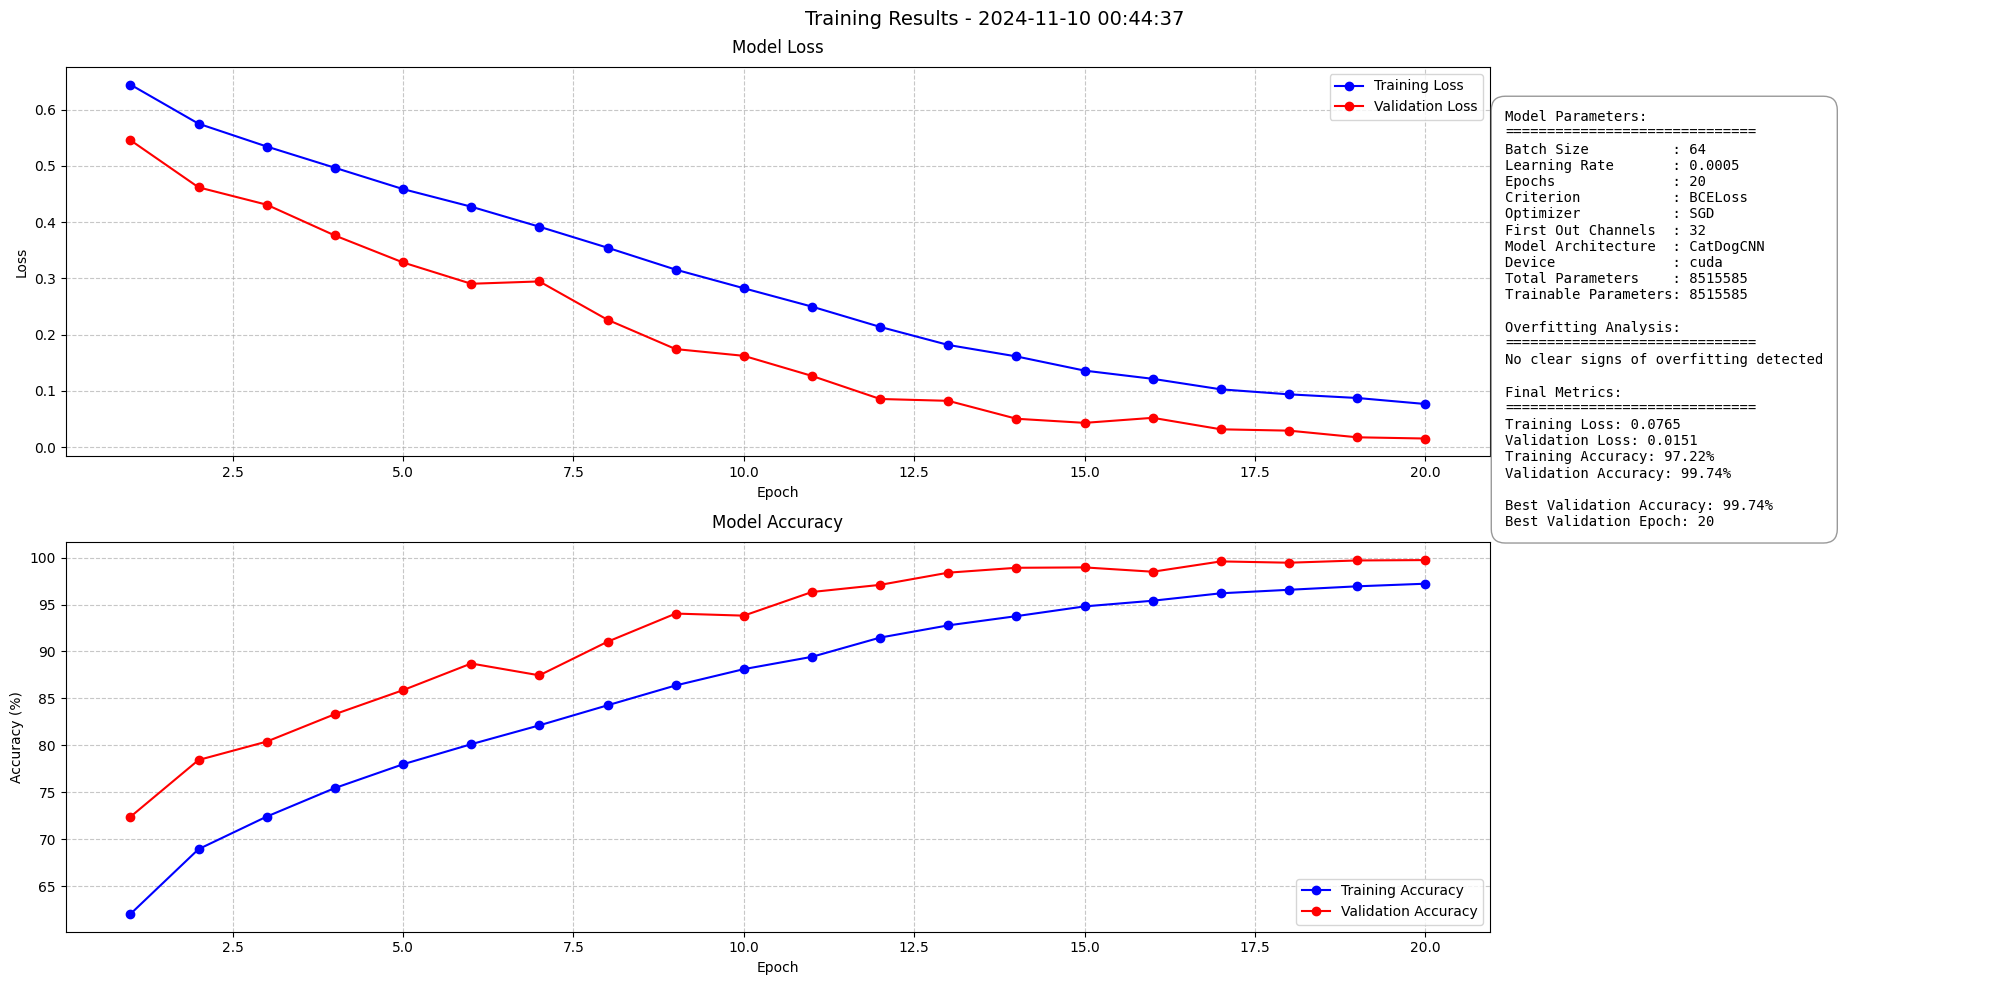

Training with neurons: 64, batch_size: 32, learning_rate: 0.005

Epoch 1/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 107.89it/s]


Train Loss: 0.6211, Train Acc: 65.00%
Validation Loss: 0.5335, Validation Acc: 74.46%

Epoch 2/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 107.37it/s]


Train Loss: 0.5432, Train Acc: 72.44%
Validation Loss: 0.5912, Validation Acc: 70.12%

Epoch 3/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 107.48it/s]


Train Loss: 0.4844, Train Acc: 76.48%
Validation Loss: 0.3590, Validation Acc: 84.08%

Epoch 4/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 107.18it/s]


Train Loss: 0.4321, Train Acc: 79.65%
Validation Loss: 0.2955, Validation Acc: 88.30%

Epoch 5/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 112.50it/s]


Train Loss: 0.3747, Train Acc: 82.77%
Validation Loss: 0.2118, Validation Acc: 92.96%

Epoch 6/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 109.66it/s]


Train Loss: 0.3165, Train Acc: 85.96%
Validation Loss: 0.1558, Validation Acc: 94.38%

Epoch 7/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 107.81it/s]


Train Loss: 0.2653, Train Acc: 88.39%
Validation Loss: 0.1015, Validation Acc: 96.80%

Epoch 8/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 108.60it/s]


Train Loss: 0.2174, Train Acc: 90.72%
Validation Loss: 0.0667, Validation Acc: 97.66%

Epoch 9/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 104.44it/s]


Train Loss: 0.1785, Train Acc: 92.71%
Validation Loss: 0.0362, Validation Acc: 99.08%

Epoch 10/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 106.55it/s]


Train Loss: 0.1450, Train Acc: 94.12%
Validation Loss: 0.0282, Validation Acc: 99.32%

Epoch 11/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 109.64it/s]


Train Loss: 0.1229, Train Acc: 95.17%
Validation Loss: 0.0182, Validation Acc: 99.70%

Epoch 12/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 109.57it/s]


Train Loss: 0.1012, Train Acc: 96.15%
Validation Loss: 0.0223, Validation Acc: 99.60%

Epoch 13/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 111.77it/s]


Train Loss: 0.0847, Train Acc: 96.69%
Validation Loss: 0.0157, Validation Acc: 99.80%

Epoch 14/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 110.78it/s]


Train Loss: 0.0730, Train Acc: 97.21%
Validation Loss: 0.0113, Validation Acc: 99.74%

Epoch 15/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 110.64it/s]


Train Loss: 0.0664, Train Acc: 97.59%
Validation Loss: 0.0253, Validation Acc: 99.50%

Epoch 16/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 105.09it/s]


Train Loss: 0.0583, Train Acc: 97.84%
Validation Loss: 0.0257, Validation Acc: 99.44%

Epoch 17/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 106.98it/s]


Train Loss: 0.0495, Train Acc: 98.25%
Validation Loss: 0.0061, Validation Acc: 99.92%

Epoch 18/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 109.52it/s]


Train Loss: 0.0437, Train Acc: 98.44%
Validation Loss: 0.0068, Validation Acc: 99.92%

Epoch 19/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 109.71it/s]


Train Loss: 0.0425, Train Acc: 98.45%
Validation Loss: 0.0051, Validation Acc: 99.84%

Epoch 20/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 107.91it/s]


Train Loss: 0.0370, Train Acc: 98.67%
Validation Loss: 0.0098, Validation Acc: 99.88%


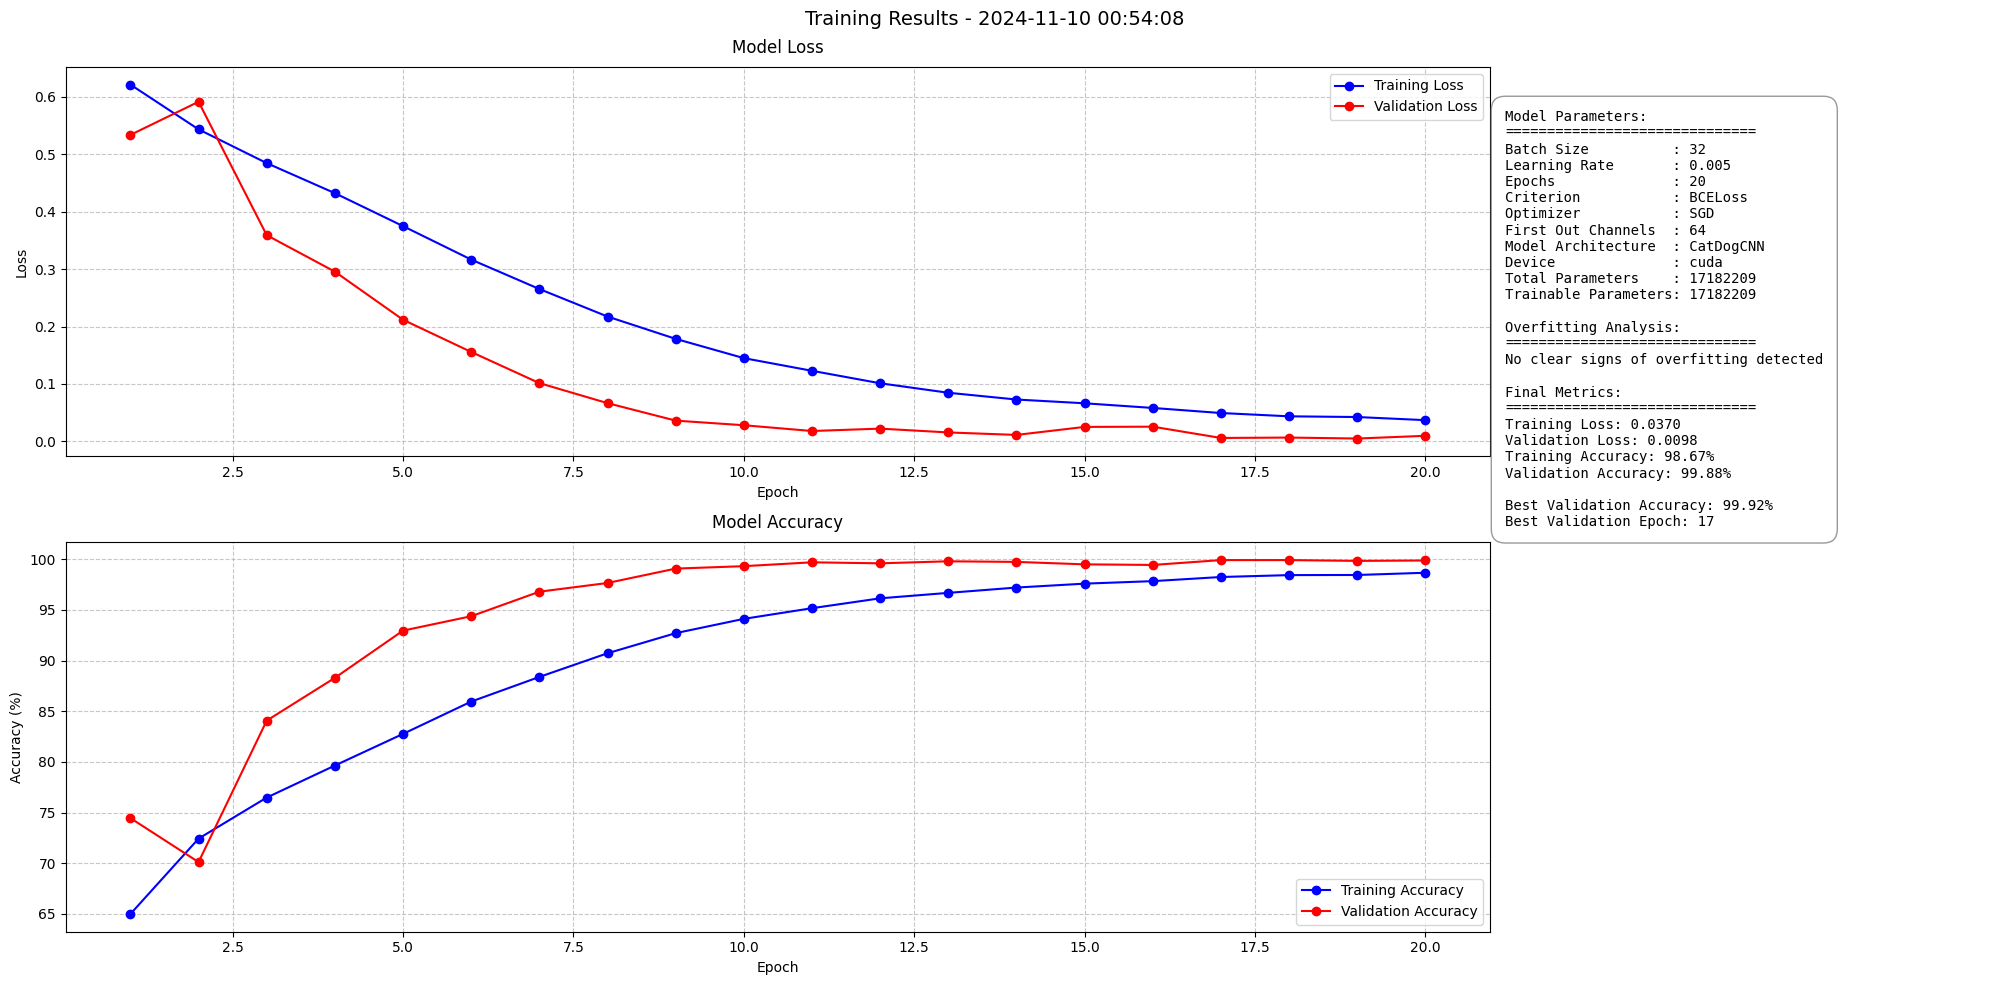

Training with neurons: 64, batch_size: 32, learning_rate: 0.001

Epoch 1/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 109.60it/s]


Train Loss: 0.6088, Train Acc: 65.77%
Validation Loss: 0.4893, Validation Acc: 76.22%

Epoch 2/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 108.78it/s]


Train Loss: 0.5313, Train Acc: 72.59%
Validation Loss: 0.4124, Validation Acc: 81.10%

Epoch 3/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 110.44it/s]


Train Loss: 0.4769, Train Acc: 76.47%
Validation Loss: 0.3413, Validation Acc: 84.90%

Epoch 4/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 107.54it/s]


Train Loss: 0.4244, Train Acc: 80.07%
Validation Loss: 0.4558, Validation Acc: 80.36%

Epoch 5/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 109.38it/s]


Train Loss: 0.3726, Train Acc: 83.03%
Validation Loss: 0.2317, Validation Acc: 90.82%

Epoch 6/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 107.97it/s]


Train Loss: 0.3209, Train Acc: 85.78%
Validation Loss: 0.1482, Validation Acc: 94.30%

Epoch 7/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 109.35it/s]


Train Loss: 0.2706, Train Acc: 88.24%
Validation Loss: 0.1090, Validation Acc: 96.10%

Epoch 8/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 108.35it/s]


Train Loss: 0.2192, Train Acc: 90.81%
Validation Loss: 0.0979, Validation Acc: 96.70%

Epoch 9/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 107.97it/s]


Train Loss: 0.1829, Train Acc: 92.47%
Validation Loss: 0.0544, Validation Acc: 98.56%

Epoch 10/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 107.68it/s]


Train Loss: 0.1503, Train Acc: 94.07%
Validation Loss: 0.0315, Validation Acc: 99.52%

Epoch 11/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 108.73it/s]


Train Loss: 0.1229, Train Acc: 95.20%
Validation Loss: 0.0300, Validation Acc: 99.16%

Epoch 12/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 109.58it/s]


Train Loss: 0.1036, Train Acc: 96.26%
Validation Loss: 0.0224, Validation Acc: 99.36%

Epoch 13/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 108.65it/s]


Train Loss: 0.0868, Train Acc: 96.83%
Validation Loss: 0.0142, Validation Acc: 99.68%

Epoch 14/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 110.20it/s]


Train Loss: 0.0760, Train Acc: 97.17%
Validation Loss: 0.0247, Validation Acc: 99.16%

Epoch 15/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 109.64it/s]


Train Loss: 0.0672, Train Acc: 97.56%
Validation Loss: 0.0096, Validation Acc: 99.68%

Epoch 16/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 109.97it/s]


Train Loss: 0.0617, Train Acc: 97.78%
Validation Loss: 0.0312, Validation Acc: 98.90%

Epoch 17/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 106.97it/s]


Train Loss: 0.0546, Train Acc: 98.06%
Validation Loss: 0.0070, Validation Acc: 99.80%

Epoch 18/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 109.62it/s]


Train Loss: 0.0471, Train Acc: 98.31%
Validation Loss: 0.0121, Validation Acc: 99.64%

Epoch 19/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 108.29it/s]


Train Loss: 0.0423, Train Acc: 98.54%
Validation Loss: 0.0030, Validation Acc: 99.90%

Epoch 20/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 109.53it/s]


Train Loss: 0.0370, Train Acc: 98.66%
Validation Loss: 0.0040, Validation Acc: 99.94%


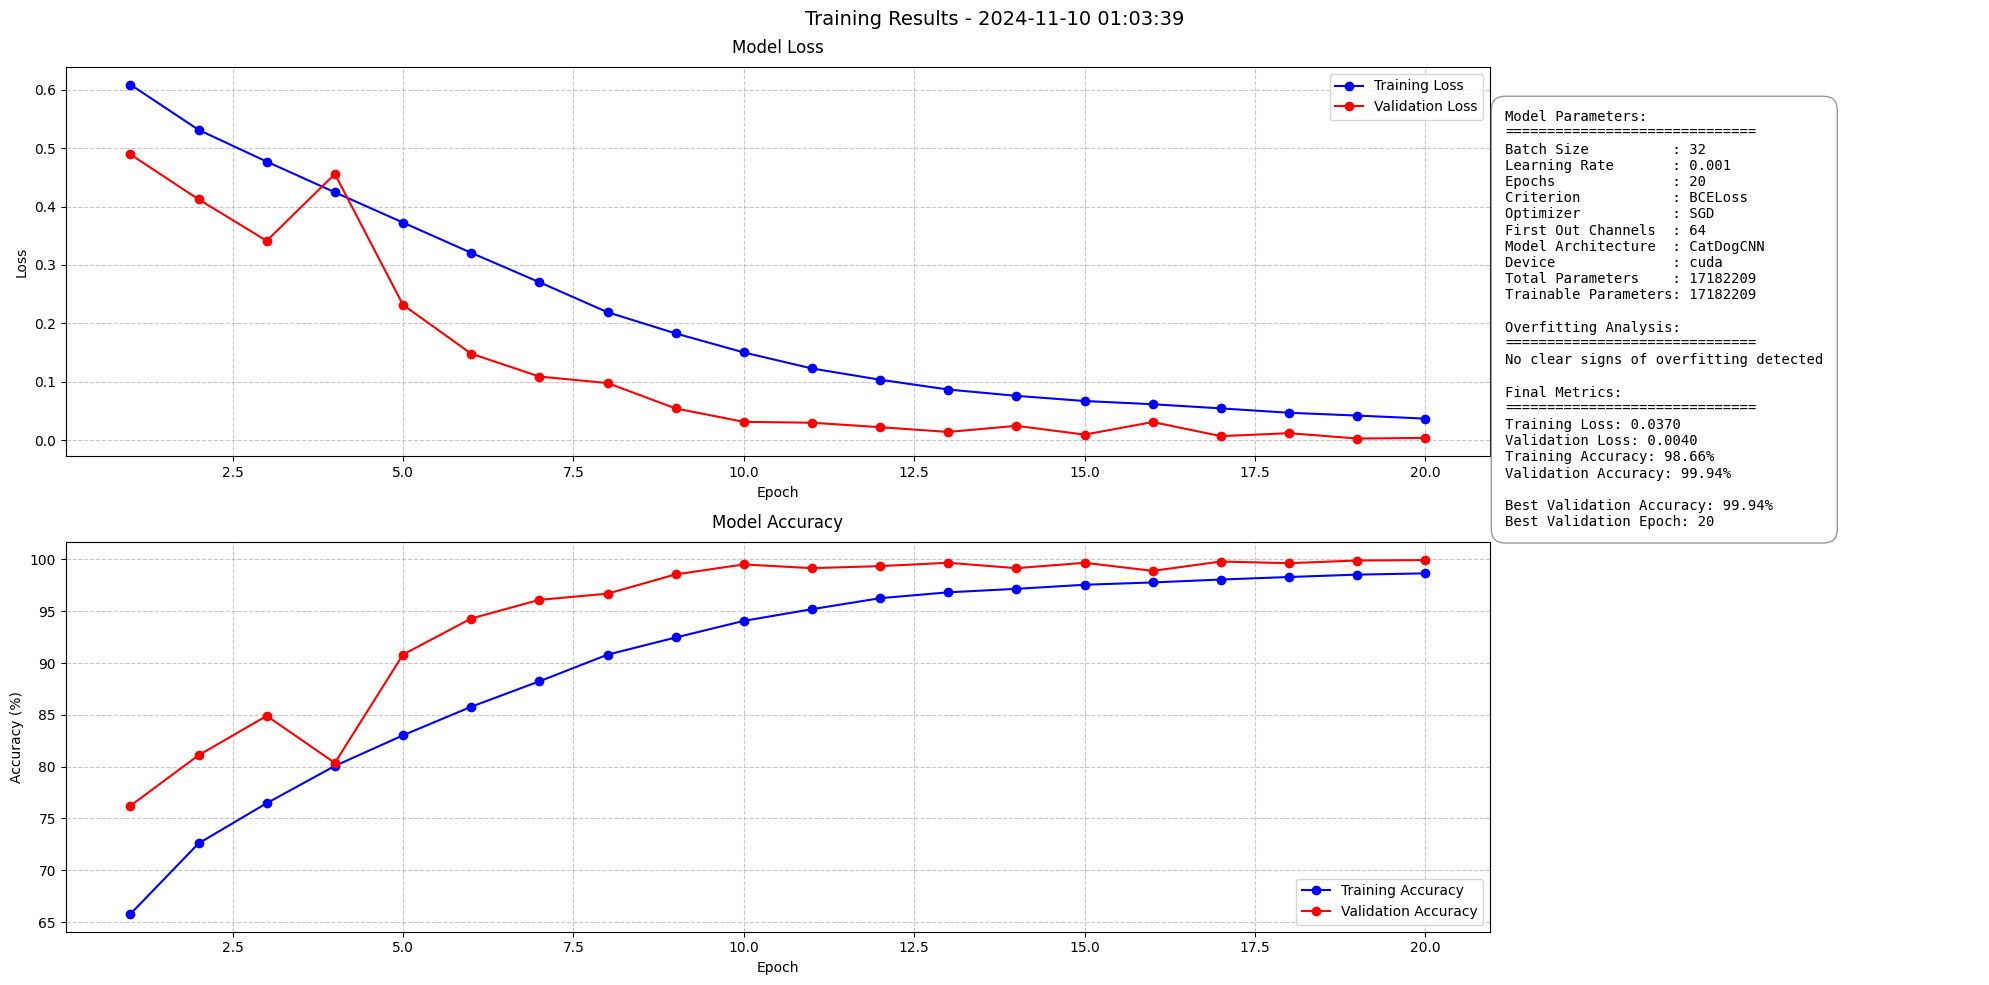

Training with neurons: 64, batch_size: 32, learning_rate: 0.0005

Epoch 1/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 108.22it/s]


Train Loss: 0.6264, Train Acc: 63.48%
Validation Loss: 0.4989, Validation Acc: 76.08%

Epoch 2/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 108.43it/s]


Train Loss: 0.5480, Train Acc: 71.16%
Validation Loss: 0.4153, Validation Acc: 80.60%

Epoch 3/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 108.59it/s]


Train Loss: 0.4949, Train Acc: 75.33%
Validation Loss: 0.3796, Validation Acc: 82.96%

Epoch 4/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 108.11it/s]


Train Loss: 0.4470, Train Acc: 78.47%
Validation Loss: 0.2901, Validation Acc: 88.08%

Epoch 5/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 107.02it/s]


Train Loss: 0.3985, Train Acc: 81.44%
Validation Loss: 0.2382, Validation Acc: 90.56%

Epoch 6/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 107.80it/s]


Train Loss: 0.3442, Train Acc: 84.61%
Validation Loss: 0.1781, Validation Acc: 93.74%

Epoch 7/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 110.56it/s]


Train Loss: 0.2968, Train Acc: 87.04%
Validation Loss: 0.1310, Validation Acc: 95.82%

Epoch 8/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 109.69it/s]


Train Loss: 0.2470, Train Acc: 89.61%
Validation Loss: 0.1016, Validation Acc: 96.42%

Epoch 9/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 108.75it/s]


Train Loss: 0.2059, Train Acc: 91.59%
Validation Loss: 0.0875, Validation Acc: 96.94%

Epoch 10/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 109.87it/s]


Train Loss: 0.1664, Train Acc: 93.33%
Validation Loss: 0.0621, Validation Acc: 98.02%

Epoch 11/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 105.56it/s]


Train Loss: 0.1409, Train Acc: 94.66%
Validation Loss: 0.0507, Validation Acc: 98.46%

Epoch 12/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 107.59it/s]


Train Loss: 0.1213, Train Acc: 95.31%
Validation Loss: 0.0267, Validation Acc: 99.30%

Epoch 13/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 108.91it/s]


Train Loss: 0.1030, Train Acc: 96.05%
Validation Loss: 0.0219, Validation Acc: 99.30%

Epoch 14/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 110.23it/s]


Train Loss: 0.0854, Train Acc: 96.81%
Validation Loss: 0.0218, Validation Acc: 99.58%

Epoch 15/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 112.86it/s]


Train Loss: 0.0753, Train Acc: 97.28%
Validation Loss: 0.0110, Validation Acc: 99.70%

Epoch 16/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 112.38it/s]


Train Loss: 0.0666, Train Acc: 97.53%
Validation Loss: 0.0119, Validation Acc: 99.60%

Epoch 17/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 109.85it/s]


Train Loss: 0.0577, Train Acc: 97.93%
Validation Loss: 0.0096, Validation Acc: 99.76%

Epoch 18/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 102.76it/s]


Train Loss: 0.0572, Train Acc: 98.02%
Validation Loss: 0.0054, Validation Acc: 99.92%

Epoch 19/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 107.77it/s]


Train Loss: 0.0482, Train Acc: 98.33%
Validation Loss: 0.0046, Validation Acc: 99.84%

Epoch 20/20


Validation: 100%|██████████| 157/157 [00:01<00:00, 108.84it/s]


Train Loss: 0.0413, Train Acc: 98.63%
Validation Loss: 0.0041, Validation Acc: 99.90%


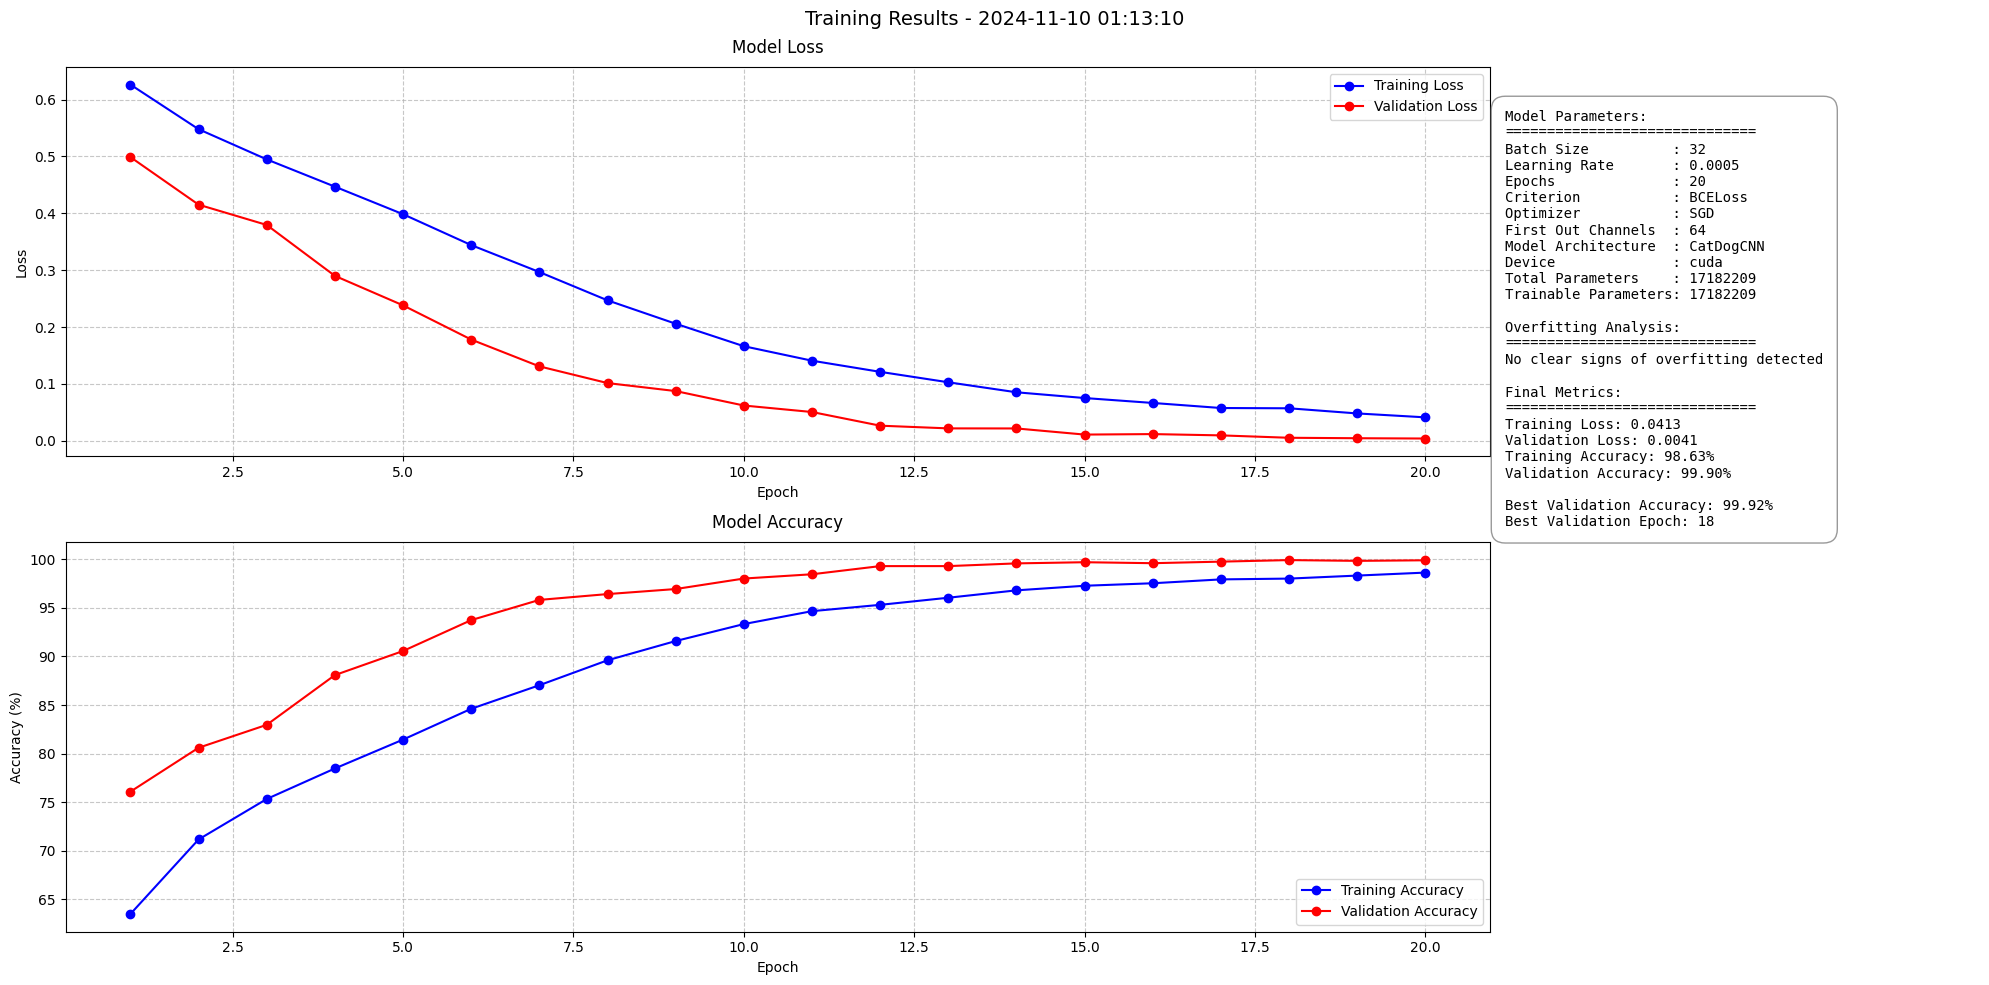

Training with neurons: 64, batch_size: 64, learning_rate: 0.005

Epoch 1/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.11it/s]


Train Loss: 0.6157, Train Acc: 65.11%
Validation Loss: 0.4820, Validation Acc: 76.74%

Epoch 2/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.27it/s]


Train Loss: 0.5335, Train Acc: 72.68%
Validation Loss: 0.4186, Validation Acc: 81.20%

Epoch 3/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.53it/s]


Train Loss: 0.4750, Train Acc: 76.59%
Validation Loss: 0.3643, Validation Acc: 85.32%

Epoch 4/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 60.93it/s]


Train Loss: 0.4204, Train Acc: 80.43%
Validation Loss: 0.3666, Validation Acc: 82.58%

Epoch 5/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.86it/s]


Train Loss: 0.3662, Train Acc: 83.22%
Validation Loss: 0.2253, Validation Acc: 91.92%

Epoch 6/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.96it/s]


Train Loss: 0.3110, Train Acc: 86.22%
Validation Loss: 0.1477, Validation Acc: 95.70%

Epoch 7/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.80it/s]


Train Loss: 0.2592, Train Acc: 88.89%
Validation Loss: 0.1800, Validation Acc: 92.60%

Epoch 8/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.40it/s]


Train Loss: 0.2107, Train Acc: 91.11%
Validation Loss: 0.0827, Validation Acc: 97.54%

Epoch 9/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.36it/s]


Train Loss: 0.1695, Train Acc: 93.07%
Validation Loss: 0.0786, Validation Acc: 96.94%

Epoch 10/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.85it/s]


Train Loss: 0.1366, Train Acc: 94.64%
Validation Loss: 0.0364, Validation Acc: 99.24%

Epoch 11/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.84it/s]


Train Loss: 0.1144, Train Acc: 95.58%
Validation Loss: 0.0589, Validation Acc: 98.10%

Epoch 12/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.59it/s]


Train Loss: 0.0881, Train Acc: 96.67%
Validation Loss: 0.0156, Validation Acc: 99.66%

Epoch 13/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.05it/s]


Train Loss: 0.0780, Train Acc: 97.06%
Validation Loss: 0.0249, Validation Acc: 99.08%

Epoch 14/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.58it/s]


Train Loss: 0.0710, Train Acc: 97.42%
Validation Loss: 0.0100, Validation Acc: 99.88%

Epoch 15/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.72it/s]


Train Loss: 0.0552, Train Acc: 98.01%
Validation Loss: 0.0097, Validation Acc: 99.82%

Epoch 16/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.26it/s]


Train Loss: 0.0525, Train Acc: 97.99%
Validation Loss: 0.0112, Validation Acc: 99.68%

Epoch 17/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.87it/s]


Train Loss: 0.0481, Train Acc: 98.28%
Validation Loss: 0.0077, Validation Acc: 99.76%

Epoch 18/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.53it/s]


Train Loss: 0.0414, Train Acc: 98.47%
Validation Loss: 0.0064, Validation Acc: 99.88%

Epoch 19/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.71it/s]


Train Loss: 0.0389, Train Acc: 98.61%
Validation Loss: 0.0112, Validation Acc: 99.78%

Epoch 20/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.81it/s]


Train Loss: 0.0317, Train Acc: 98.83%
Validation Loss: 0.0025, Validation Acc: 99.96%


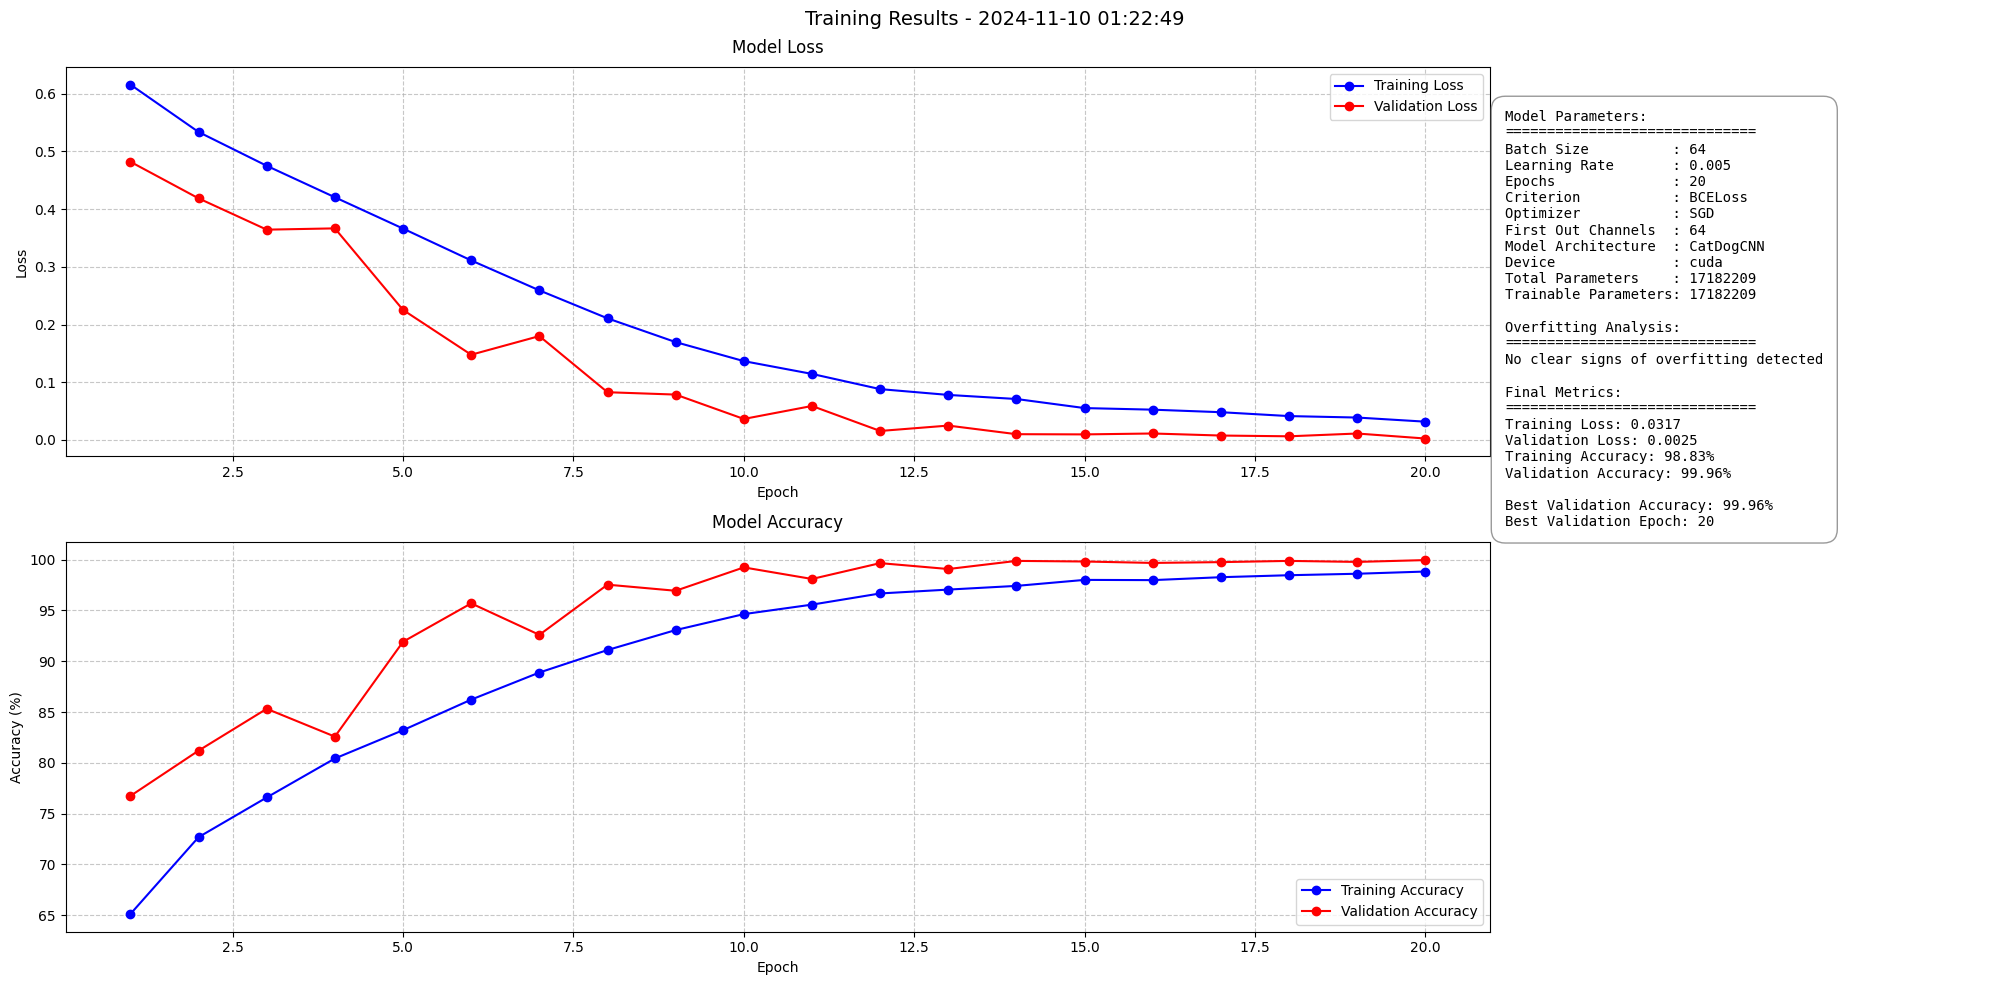

Training with neurons: 64, batch_size: 64, learning_rate: 0.001

Epoch 1/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.80it/s]


Train Loss: 0.6212, Train Acc: 64.22%
Validation Loss: 0.4974, Validation Acc: 75.76%

Epoch 2/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.98it/s]


Train Loss: 0.5501, Train Acc: 71.05%
Validation Loss: 0.4224, Validation Acc: 80.62%

Epoch 3/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.53it/s]


Train Loss: 0.4959, Train Acc: 75.32%
Validation Loss: 0.4685, Validation Acc: 77.78%

Epoch 4/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.08it/s]


Train Loss: 0.4476, Train Acc: 78.61%
Validation Loss: 0.2978, Validation Acc: 86.90%

Epoch 5/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.23it/s]


Train Loss: 0.3998, Train Acc: 81.38%
Validation Loss: 0.2908, Validation Acc: 87.18%

Epoch 6/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.83it/s]


Train Loss: 0.3532, Train Acc: 84.14%
Validation Loss: 0.2153, Validation Acc: 91.38%

Epoch 7/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.34it/s]


Train Loss: 0.3021, Train Acc: 86.75%
Validation Loss: 0.2167, Validation Acc: 91.16%

Epoch 8/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.33it/s]


Train Loss: 0.2515, Train Acc: 89.36%
Validation Loss: 0.0970, Validation Acc: 96.54%

Epoch 9/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 55.18it/s]


Train Loss: 0.2077, Train Acc: 91.38%
Validation Loss: 0.0701, Validation Acc: 97.64%

Epoch 10/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.86it/s]


Train Loss: 0.1698, Train Acc: 93.16%
Validation Loss: 0.1208, Validation Acc: 95.46%

Epoch 11/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.61it/s]


Train Loss: 0.1432, Train Acc: 94.34%
Validation Loss: 0.0336, Validation Acc: 99.00%

Epoch 12/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.82it/s]


Train Loss: 0.1181, Train Acc: 95.42%
Validation Loss: 0.0257, Validation Acc: 99.48%

Epoch 13/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.08it/s]


Train Loss: 0.0986, Train Acc: 96.25%
Validation Loss: 0.0318, Validation Acc: 98.96%

Epoch 14/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.48it/s]


Train Loss: 0.0902, Train Acc: 96.70%
Validation Loss: 0.0289, Validation Acc: 99.10%

Epoch 15/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 54.14it/s]


Train Loss: 0.0786, Train Acc: 97.09%
Validation Loss: 0.0188, Validation Acc: 99.62%

Epoch 16/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.27it/s]


Train Loss: 0.0673, Train Acc: 97.54%
Validation Loss: 0.0086, Validation Acc: 99.80%

Epoch 17/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.28it/s]


Train Loss: 0.0609, Train Acc: 97.82%
Validation Loss: 0.0217, Validation Acc: 99.38%

Epoch 18/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 58.46it/s]


Train Loss: 0.0520, Train Acc: 98.18%
Validation Loss: 0.0226, Validation Acc: 99.28%

Epoch 19/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.80it/s]


Train Loss: 0.0459, Train Acc: 98.36%
Validation Loss: 0.0042, Validation Acc: 99.90%

Epoch 20/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 58.20it/s]


Train Loss: 0.0405, Train Acc: 98.53%
Validation Loss: 0.0030, Validation Acc: 99.98%


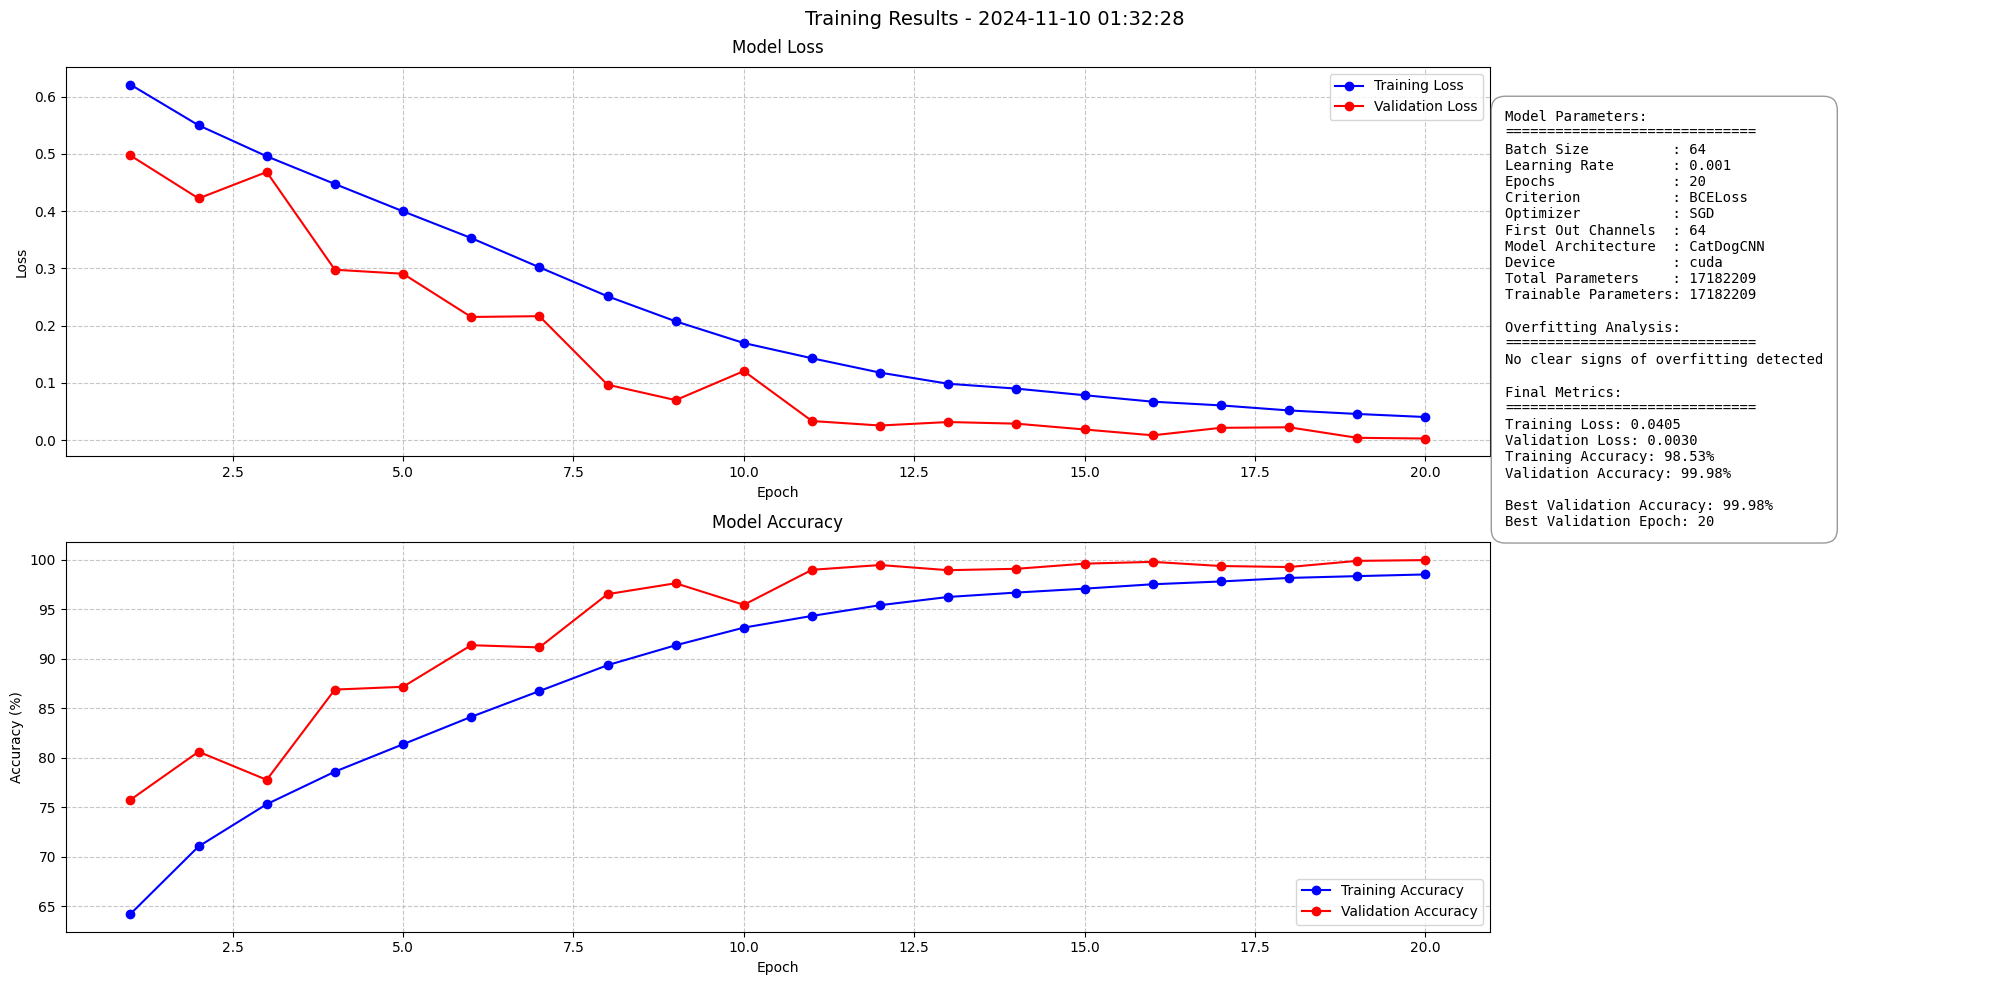

Training with neurons: 64, batch_size: 64, learning_rate: 0.0005

Epoch 1/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.36it/s]


Train Loss: 0.6332, Train Acc: 63.20%
Validation Loss: 0.5254, Validation Acc: 73.98%

Epoch 2/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 55.48it/s]


Train Loss: 0.5640, Train Acc: 69.97%
Validation Loss: 0.4373, Validation Acc: 79.60%

Epoch 3/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 28.62it/s]


Train Loss: 0.5135, Train Acc: 73.95%
Validation Loss: 0.4120, Validation Acc: 80.88%

Epoch 4/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.74it/s]


Train Loss: 0.4682, Train Acc: 77.35%
Validation Loss: 0.3413, Validation Acc: 84.84%

Epoch 5/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.44it/s]


Train Loss: 0.4223, Train Acc: 79.94%
Validation Loss: 0.2782, Validation Acc: 88.88%

Epoch 6/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 55.50it/s]


Train Loss: 0.3767, Train Acc: 83.04%
Validation Loss: 0.2574, Validation Acc: 89.46%

Epoch 7/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.14it/s]


Train Loss: 0.3313, Train Acc: 85.33%
Validation Loss: 0.2819, Validation Acc: 87.66%

Epoch 8/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.04it/s]


Train Loss: 0.2796, Train Acc: 88.05%
Validation Loss: 0.1471, Validation Acc: 95.00%

Epoch 9/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.68it/s]


Train Loss: 0.2336, Train Acc: 90.32%
Validation Loss: 0.1014, Validation Acc: 97.26%

Epoch 10/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.88it/s]


Train Loss: 0.1900, Train Acc: 92.37%
Validation Loss: 0.0696, Validation Acc: 98.26%

Epoch 11/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.73it/s]


Train Loss: 0.1583, Train Acc: 93.76%
Validation Loss: 0.0818, Validation Acc: 97.72%

Epoch 12/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.76it/s]


Train Loss: 0.1314, Train Acc: 94.99%
Validation Loss: 0.0628, Validation Acc: 97.82%

Epoch 13/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.69it/s]


Train Loss: 0.1125, Train Acc: 95.81%
Validation Loss: 0.0261, Validation Acc: 99.48%

Epoch 14/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.09it/s]


Train Loss: 0.0901, Train Acc: 96.72%
Validation Loss: 0.0168, Validation Acc: 99.70%

Epoch 15/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.57it/s]


Train Loss: 0.0803, Train Acc: 97.07%
Validation Loss: 0.0208, Validation Acc: 99.64%

Epoch 16/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.66it/s]


Train Loss: 0.0731, Train Acc: 97.32%
Validation Loss: 0.0197, Validation Acc: 99.60%

Epoch 17/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.54it/s]


Train Loss: 0.0625, Train Acc: 97.82%
Validation Loss: 0.0100, Validation Acc: 99.82%

Epoch 18/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.19it/s]


Train Loss: 0.0589, Train Acc: 97.89%
Validation Loss: 0.0105, Validation Acc: 99.80%

Epoch 19/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.03it/s]


Train Loss: 0.0528, Train Acc: 98.06%
Validation Loss: 0.0094, Validation Acc: 99.88%

Epoch 20/20


Validation: 100%|██████████| 79/79 [00:01<00:00, 56.64it/s]


Train Loss: 0.0472, Train Acc: 98.35%
Validation Loss: 0.0168, Validation Acc: 99.52%


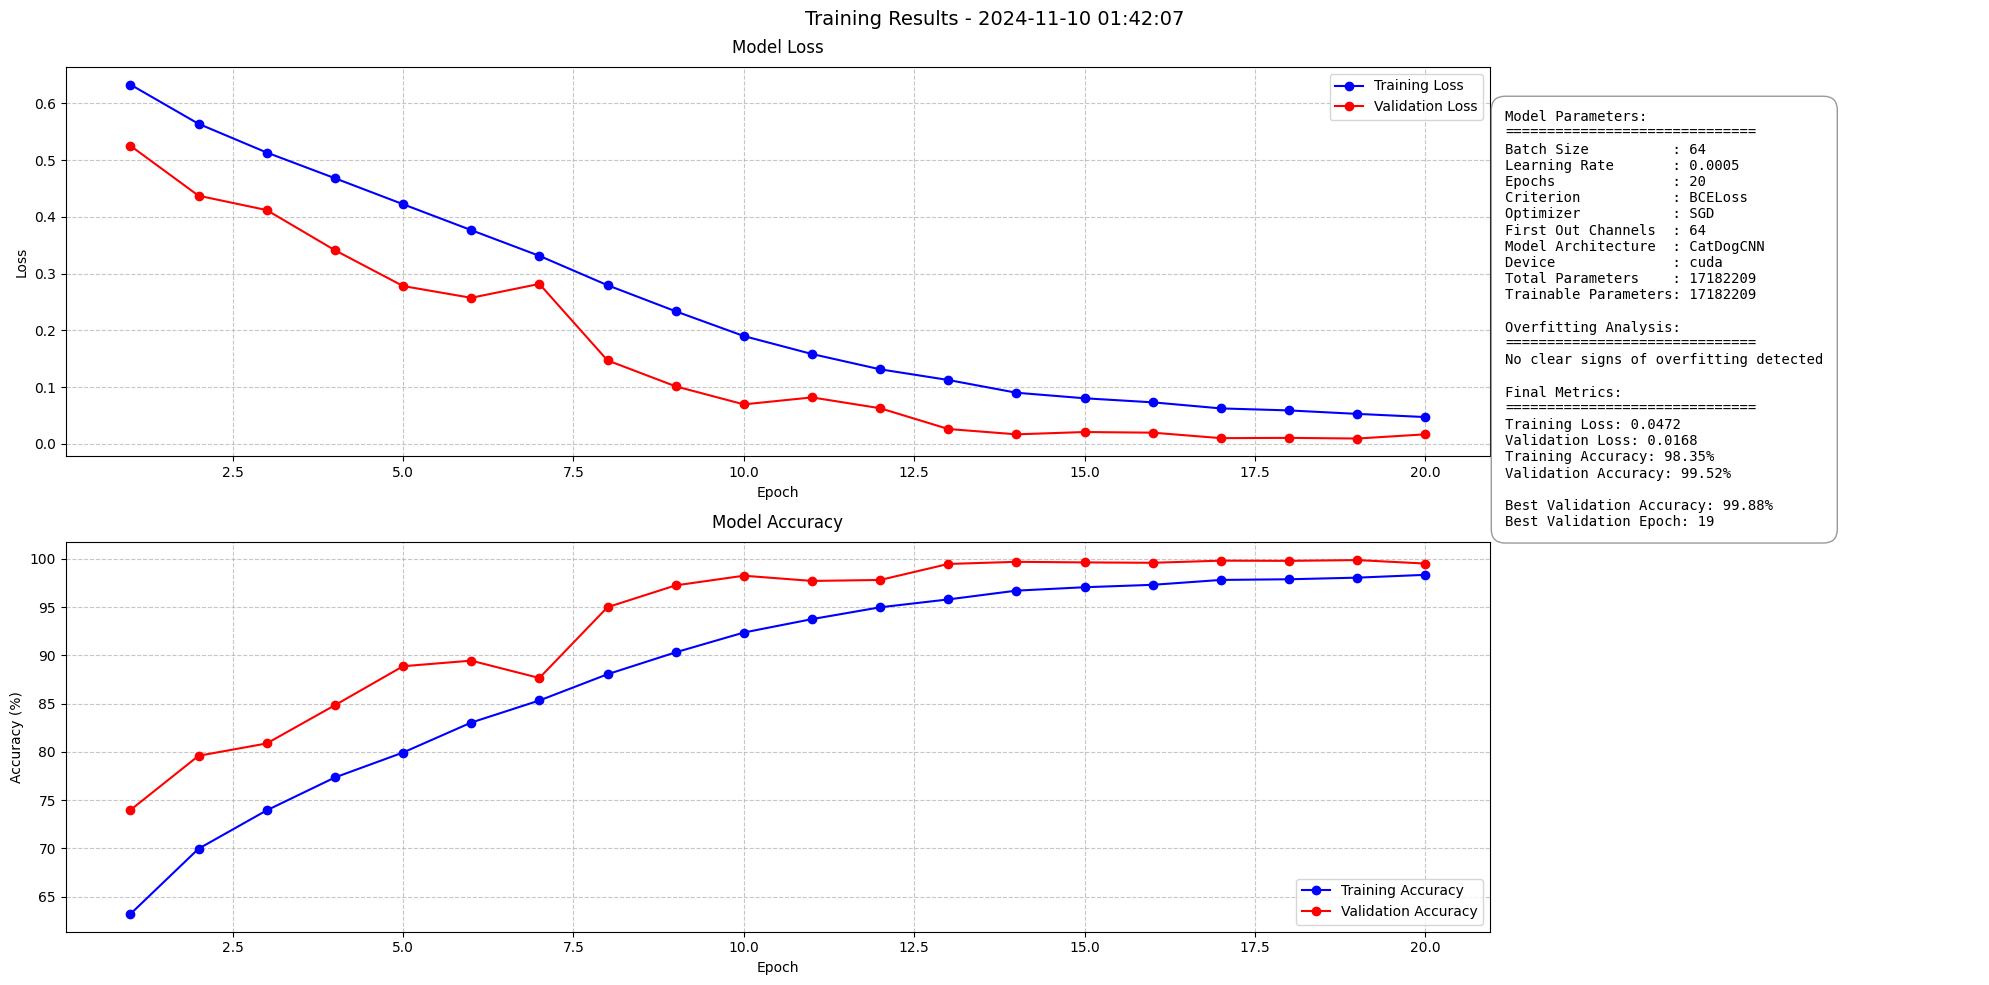

Training with neurons: 128, batch_size: 32, learning_rate: 0.005

Epoch 1/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.21it/s]


Train Loss: 0.6211, Train Acc: 64.96%
Validation Loss: 0.5967, Validation Acc: 67.64%

Epoch 2/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 57.75it/s]


Train Loss: 0.5455, Train Acc: 72.14%
Validation Loss: 0.4212, Validation Acc: 82.18%

Epoch 3/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 57.88it/s]


Train Loss: 0.4905, Train Acc: 76.17%
Validation Loss: 0.3337, Validation Acc: 87.06%

Epoch 4/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.10it/s]


Train Loss: 0.4392, Train Acc: 79.06%
Validation Loss: 0.2791, Validation Acc: 87.10%

Epoch 5/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 57.29it/s]


Train Loss: 0.3820, Train Acc: 82.33%
Validation Loss: 0.1864, Validation Acc: 92.68%

Epoch 6/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 38.53it/s]


Train Loss: 0.3274, Train Acc: 85.51%
Validation Loss: 0.2804, Validation Acc: 89.62%

Epoch 7/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.15it/s]


Train Loss: 0.2757, Train Acc: 88.18%
Validation Loss: 0.1083, Validation Acc: 96.68%

Epoch 8/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 57.88it/s]


Train Loss: 0.2261, Train Acc: 90.45%
Validation Loss: 0.1319, Validation Acc: 97.16%

Epoch 9/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 59.20it/s]


Train Loss: 0.1839, Train Acc: 92.51%
Validation Loss: 0.0749, Validation Acc: 97.24%

Epoch 10/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 59.77it/s]


Train Loss: 0.1451, Train Acc: 94.08%
Validation Loss: 0.0271, Validation Acc: 99.34%

Epoch 11/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 59.57it/s]


Train Loss: 0.1203, Train Acc: 95.23%
Validation Loss: 0.0214, Validation Acc: 99.44%

Epoch 12/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 59.95it/s]


Train Loss: 0.1022, Train Acc: 96.09%
Validation Loss: 0.0238, Validation Acc: 99.62%

Epoch 13/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.50it/s]


Train Loss: 0.0853, Train Acc: 96.71%
Validation Loss: 0.0089, Validation Acc: 99.82%

Epoch 14/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.11it/s]


Train Loss: 0.0750, Train Acc: 97.18%
Validation Loss: 0.0190, Validation Acc: 99.58%

Epoch 15/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 38.37it/s]


Train Loss: 0.0662, Train Acc: 97.55%
Validation Loss: 0.0208, Validation Acc: 99.36%

Epoch 16/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.34it/s]


Train Loss: 0.0538, Train Acc: 97.98%
Validation Loss: 0.0084, Validation Acc: 99.88%

Epoch 17/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.04it/s]


Train Loss: 0.0470, Train Acc: 98.28%
Validation Loss: 0.0182, Validation Acc: 99.66%

Epoch 18/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.42it/s]


Train Loss: 0.0480, Train Acc: 98.21%
Validation Loss: 0.0076, Validation Acc: 99.78%

Epoch 19/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.22it/s]


Train Loss: 0.0419, Train Acc: 98.66%
Validation Loss: 0.0055, Validation Acc: 99.86%

Epoch 20/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 57.98it/s]


Train Loss: 0.0356, Train Acc: 98.69%
Validation Loss: 0.0128, Validation Acc: 99.82%


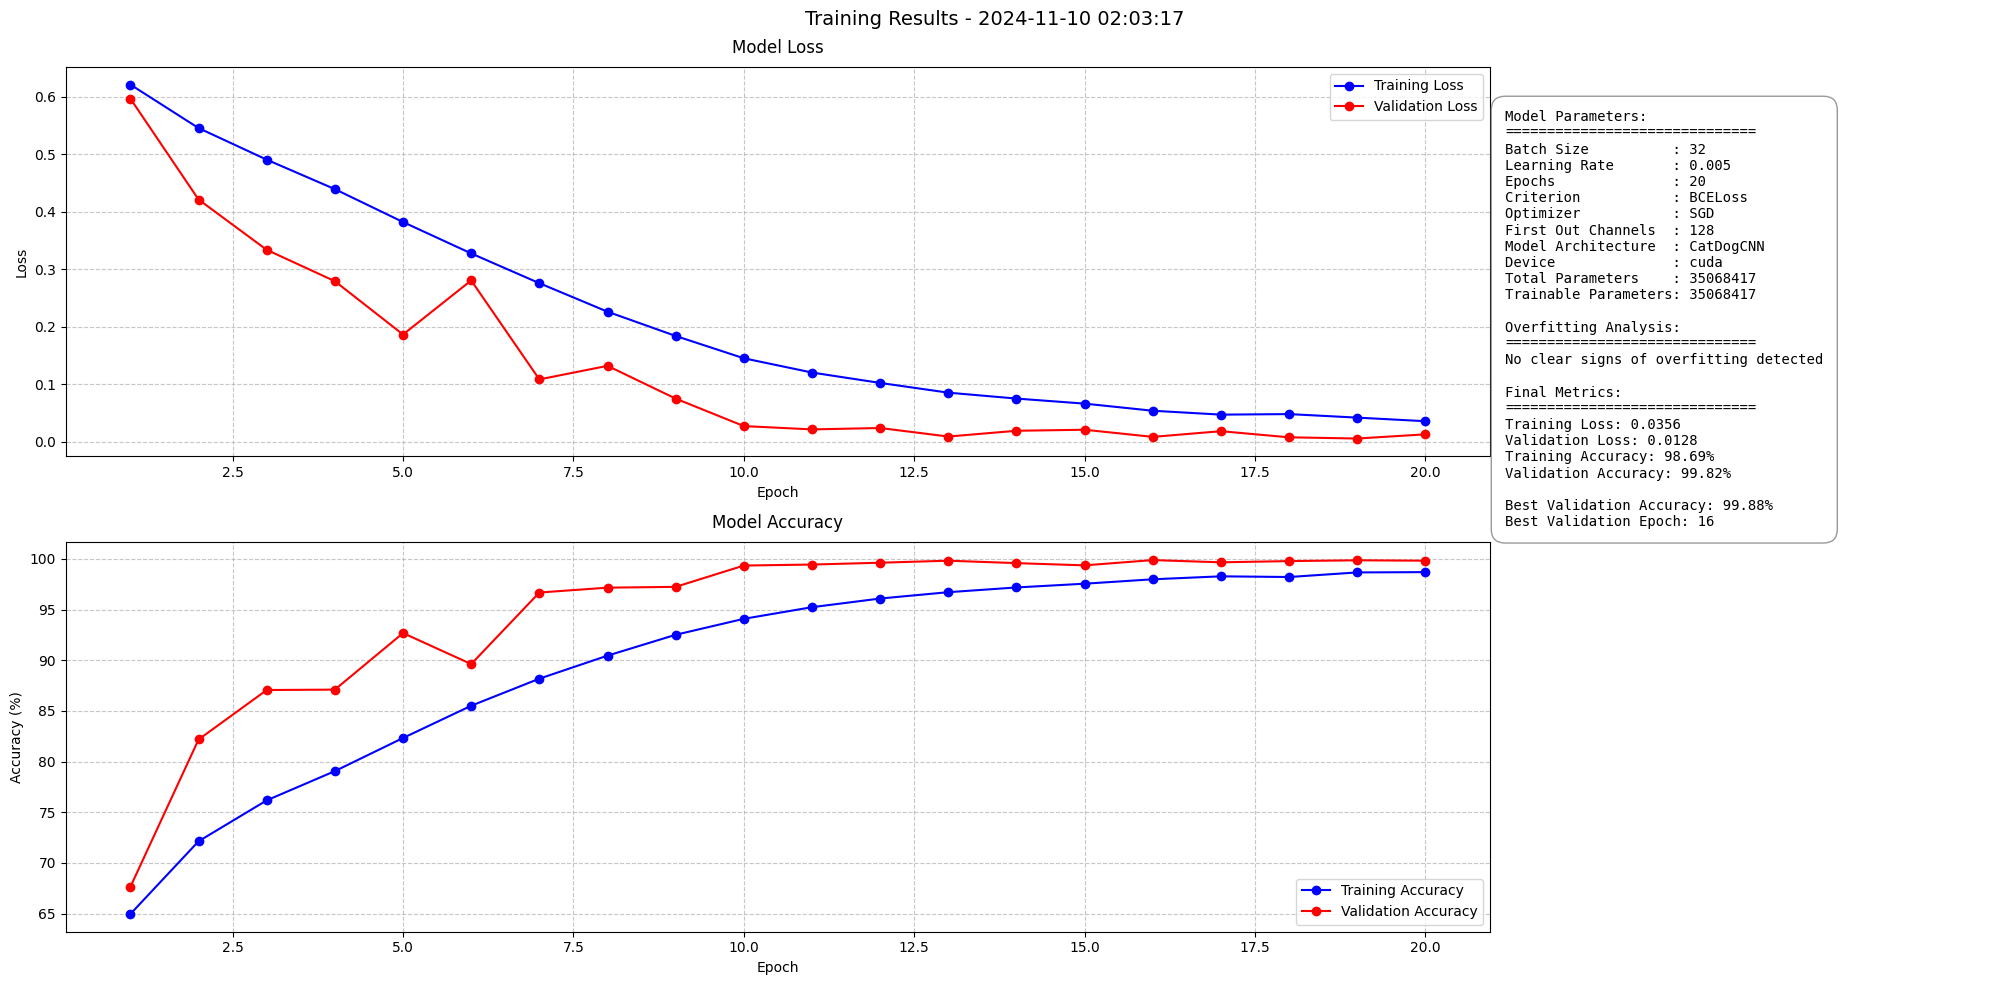

Training with neurons: 128, batch_size: 32, learning_rate: 0.001

Epoch 1/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.24it/s]


Train Loss: 0.6160, Train Acc: 64.75%
Validation Loss: 0.4757, Validation Acc: 76.76%

Epoch 2/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.23it/s]


Train Loss: 0.5303, Train Acc: 72.86%
Validation Loss: 0.3990, Validation Acc: 82.90%

Epoch 3/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 57.35it/s]


Train Loss: 0.4680, Train Acc: 77.18%
Validation Loss: 0.3193, Validation Acc: 86.48%

Epoch 4/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 38.46it/s]


Train Loss: 0.4135, Train Acc: 80.45%
Validation Loss: 0.2624, Validation Acc: 88.72%

Epoch 5/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.17it/s]


Train Loss: 0.3562, Train Acc: 83.70%
Validation Loss: 0.1815, Validation Acc: 93.20%

Epoch 6/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.21it/s]


Train Loss: 0.2994, Train Acc: 86.93%
Validation Loss: 0.2033, Validation Acc: 91.84%

Epoch 7/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 59.02it/s]


Train Loss: 0.2468, Train Acc: 89.70%
Validation Loss: 0.1001, Validation Acc: 97.22%

Epoch 8/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 59.84it/s]


Train Loss: 0.1982, Train Acc: 91.97%
Validation Loss: 0.0875, Validation Acc: 96.94%

Epoch 9/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 60.40it/s]


Train Loss: 0.1643, Train Acc: 93.37%
Validation Loss: 0.0348, Validation Acc: 99.20%

Epoch 10/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.57it/s]


Train Loss: 0.1332, Train Acc: 94.64%
Validation Loss: 0.0519, Validation Acc: 98.20%

Epoch 11/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.08it/s]


Train Loss: 0.1121, Train Acc: 95.78%
Validation Loss: 0.0619, Validation Acc: 97.84%

Epoch 12/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 38.32it/s]


Train Loss: 0.0893, Train Acc: 96.66%
Validation Loss: 0.0224, Validation Acc: 99.32%

Epoch 13/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.63it/s]


Train Loss: 0.0801, Train Acc: 97.05%
Validation Loss: 0.0212, Validation Acc: 99.36%

Epoch 14/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 57.94it/s]


Train Loss: 0.0725, Train Acc: 97.33%
Validation Loss: 0.0288, Validation Acc: 99.00%

Epoch 15/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.46it/s]


Train Loss: 0.0568, Train Acc: 98.01%
Validation Loss: 0.0142, Validation Acc: 99.66%

Epoch 16/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.26it/s]


Train Loss: 0.0557, Train Acc: 97.92%
Validation Loss: 0.0046, Validation Acc: 99.90%

Epoch 17/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.82it/s]


Train Loss: 0.0490, Train Acc: 98.22%
Validation Loss: 0.0084, Validation Acc: 99.78%

Epoch 18/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.04it/s]


Train Loss: 0.0455, Train Acc: 98.32%
Validation Loss: 0.0150, Validation Acc: 99.78%

Epoch 19/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.38it/s]


Train Loss: 0.0398, Train Acc: 98.57%
Validation Loss: 0.0045, Validation Acc: 99.94%

Epoch 20/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.16it/s]


Train Loss: 0.0308, Train Acc: 98.91%
Validation Loss: 0.0085, Validation Acc: 99.94%


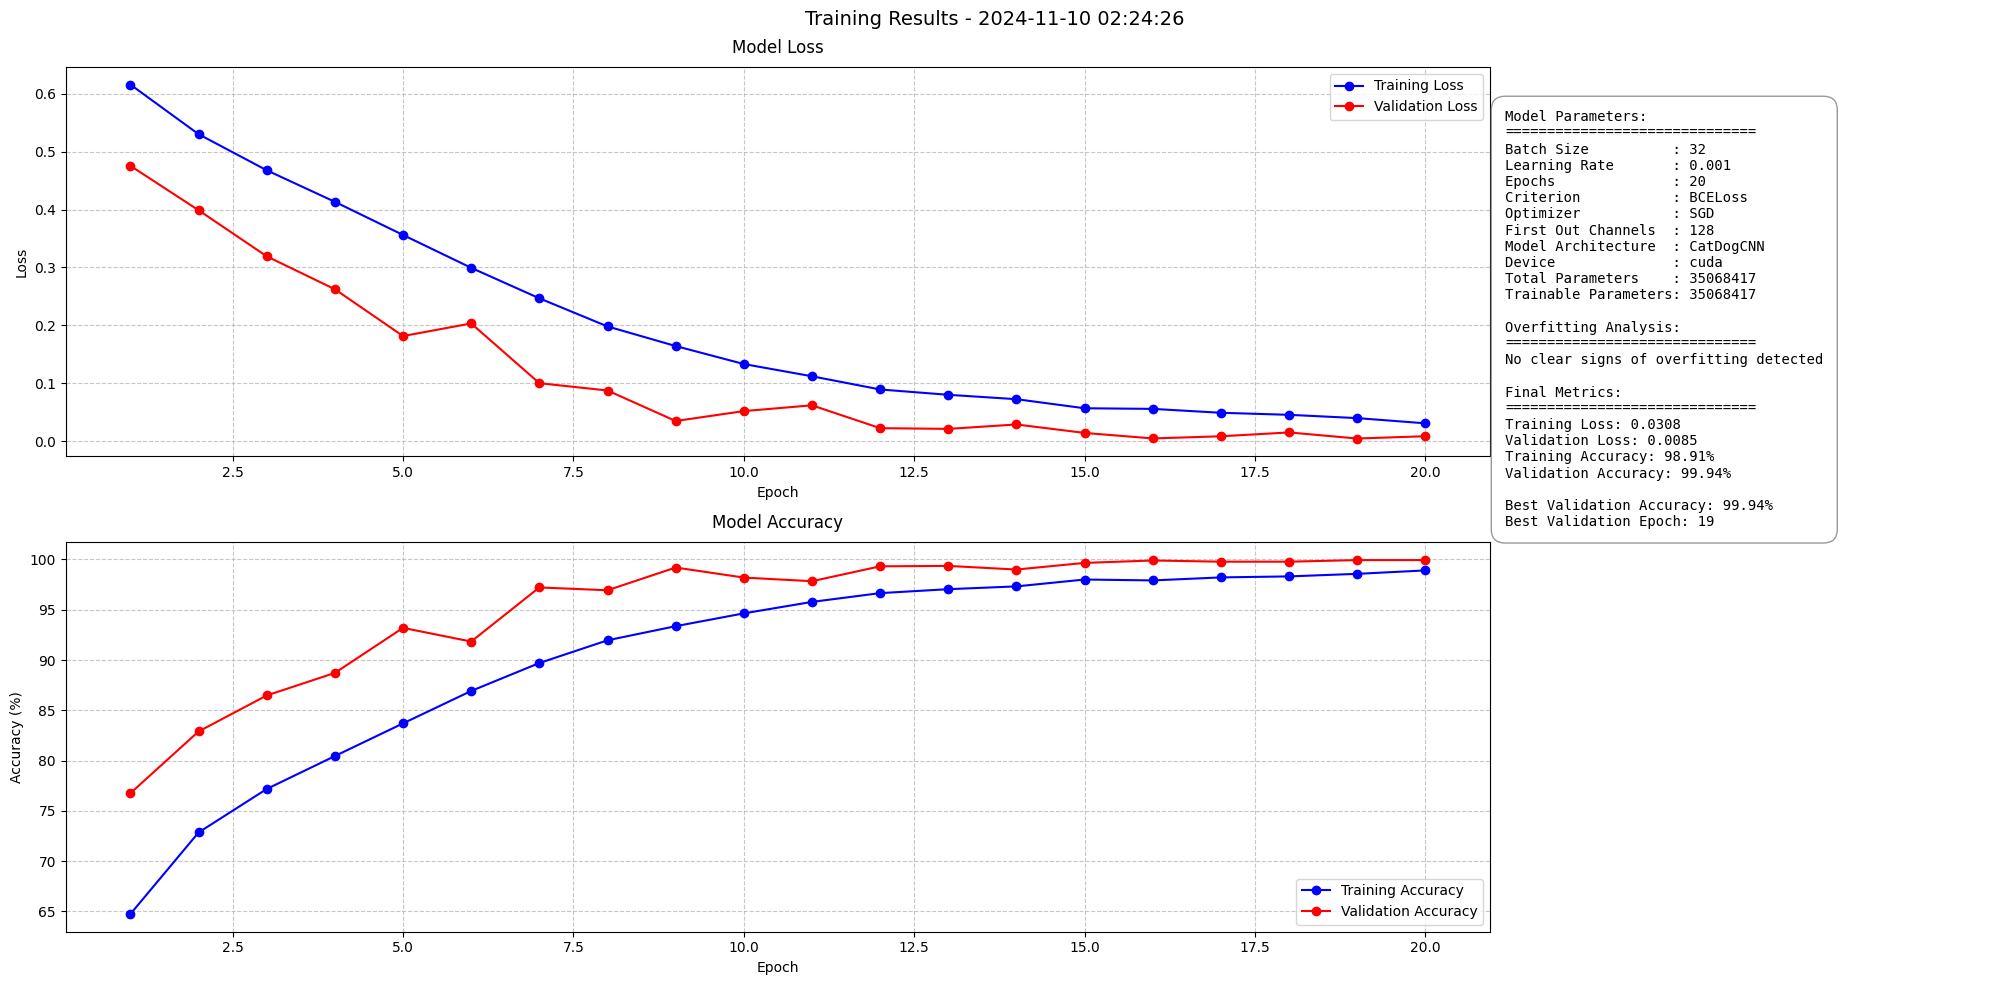

Training with neurons: 128, batch_size: 32, learning_rate: 0.0005

Epoch 1/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 37.94it/s]


Train Loss: 0.6215, Train Acc: 64.52%
Validation Loss: 0.4740, Validation Acc: 77.14%

Epoch 2/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.61it/s]


Train Loss: 0.5410, Train Acc: 71.70%
Validation Loss: 0.4196, Validation Acc: 80.64%

Epoch 3/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.41it/s]


Train Loss: 0.4807, Train Acc: 76.08%
Validation Loss: 0.3477, Validation Acc: 85.40%

Epoch 4/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 59.68it/s]


Train Loss: 0.4247, Train Acc: 79.85%
Validation Loss: 0.2944, Validation Acc: 88.72%

Epoch 5/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 60.75it/s]


Train Loss: 0.3702, Train Acc: 83.12%
Validation Loss: 0.2032, Validation Acc: 92.70%

Epoch 6/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 60.22it/s]


Train Loss: 0.3115, Train Acc: 86.11%
Validation Loss: 0.1209, Validation Acc: 96.18%

Epoch 7/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 60.00it/s]


Train Loss: 0.2523, Train Acc: 89.17%
Validation Loss: 0.0965, Validation Acc: 96.76%

Epoch 8/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.50it/s]


Train Loss: 0.2039, Train Acc: 91.52%
Validation Loss: 0.0626, Validation Acc: 98.28%

Epoch 9/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 35.11it/s]


Train Loss: 0.1582, Train Acc: 93.69%
Validation Loss: 0.0444, Validation Acc: 98.74%

Epoch 10/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.14it/s]


Train Loss: 0.1399, Train Acc: 94.54%
Validation Loss: 0.0273, Validation Acc: 99.30%

Epoch 11/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.21it/s]


Train Loss: 0.1134, Train Acc: 95.72%
Validation Loss: 0.0313, Validation Acc: 99.18%

Epoch 12/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.72it/s]


Train Loss: 0.0995, Train Acc: 96.38%
Validation Loss: 0.0249, Validation Acc: 99.44%

Epoch 13/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.29it/s]


Train Loss: 0.0823, Train Acc: 96.92%
Validation Loss: 0.0175, Validation Acc: 99.64%

Epoch 14/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.43it/s]


Train Loss: 0.0686, Train Acc: 97.51%
Validation Loss: 0.0184, Validation Acc: 99.66%

Epoch 15/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.53it/s]


Train Loss: 0.0583, Train Acc: 97.92%
Validation Loss: 0.0155, Validation Acc: 99.36%

Epoch 16/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.51it/s]


Train Loss: 0.0551, Train Acc: 98.00%
Validation Loss: 0.0173, Validation Acc: 99.88%

Epoch 17/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 37.29it/s]


Train Loss: 0.0481, Train Acc: 98.30%
Validation Loss: 0.0185, Validation Acc: 99.82%

Epoch 18/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.28it/s]


Train Loss: 0.0459, Train Acc: 98.37%
Validation Loss: 0.0220, Validation Acc: 99.82%

Epoch 19/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.91it/s]


Train Loss: 0.0396, Train Acc: 98.61%
Validation Loss: 0.0171, Validation Acc: 99.80%

Epoch 20/20


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.60it/s]


Train Loss: 0.0405, Train Acc: 98.55%
Validation Loss: 0.0182, Validation Acc: 99.96%


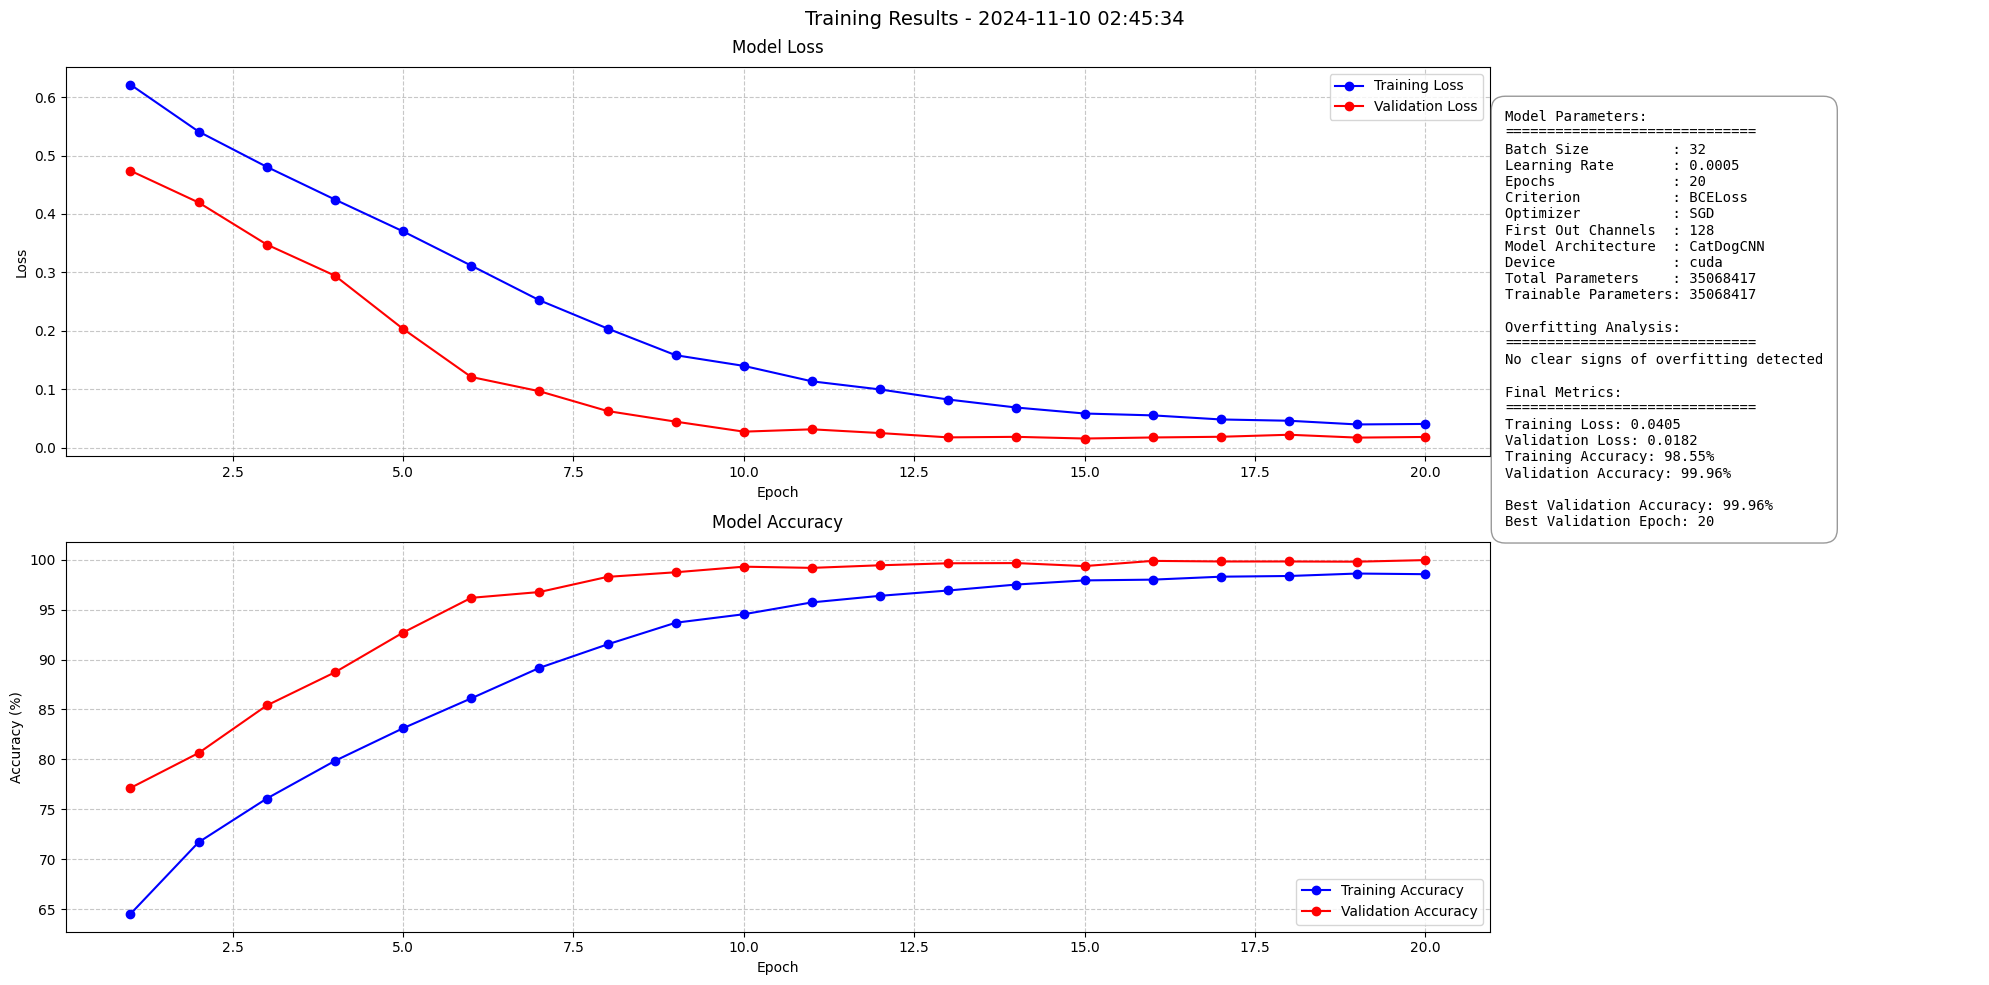

Training with neurons: 128, batch_size: 64, learning_rate: 0.005

Epoch 1/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.93it/s]


Train Loss: 0.6139, Train Acc: 65.22%
Validation Loss: 0.4925, Validation Acc: 75.44%

Epoch 2/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.60it/s]


Train Loss: 0.5216, Train Acc: 73.52%
Validation Loss: 0.4690, Validation Acc: 77.12%

Epoch 3/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.85it/s]


Train Loss: 0.4615, Train Acc: 77.66%
Validation Loss: 0.3885, Validation Acc: 81.26%

Epoch 4/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.96it/s]


Train Loss: 0.4005, Train Acc: 81.34%
Validation Loss: 0.2476, Validation Acc: 89.68%

Epoch 5/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.10it/s]


Train Loss: 0.3446, Train Acc: 84.50%
Validation Loss: 0.1853, Validation Acc: 93.00%

Epoch 6/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 28.99it/s]


Train Loss: 0.2884, Train Acc: 87.44%
Validation Loss: 0.1220, Validation Acc: 96.66%

Epoch 7/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.72it/s]


Train Loss: 0.2346, Train Acc: 90.07%
Validation Loss: 0.0900, Validation Acc: 97.00%

Epoch 8/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.30it/s]


Train Loss: 0.1839, Train Acc: 92.46%
Validation Loss: 0.0705, Validation Acc: 97.44%

Epoch 9/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.45it/s]


Train Loss: 0.1480, Train Acc: 94.11%
Validation Loss: 0.0296, Validation Acc: 99.18%

Epoch 10/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.05it/s]


Train Loss: 0.1221, Train Acc: 95.13%
Validation Loss: 0.0337, Validation Acc: 99.16%

Epoch 11/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.26it/s]


Train Loss: 0.0966, Train Acc: 96.25%
Validation Loss: 0.0356, Validation Acc: 98.82%

Epoch 12/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.48it/s]


Train Loss: 0.0827, Train Acc: 96.84%
Validation Loss: 0.0169, Validation Acc: 99.52%

Epoch 13/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.96it/s]


Train Loss: 0.0670, Train Acc: 97.53%
Validation Loss: 0.0124, Validation Acc: 99.66%

Epoch 14/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.96it/s]


Train Loss: 0.0565, Train Acc: 97.90%
Validation Loss: 0.0091, Validation Acc: 99.72%

Epoch 15/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.84it/s]


Train Loss: 0.0488, Train Acc: 98.17%
Validation Loss: 0.0204, Validation Acc: 99.32%

Epoch 16/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.14it/s]


Train Loss: 0.0477, Train Acc: 98.30%
Validation Loss: 0.0087, Validation Acc: 99.66%

Epoch 17/20


Validation: 100%|██████████| 79/79 [00:04<00:00, 19.01it/s]


Train Loss: 0.0401, Train Acc: 98.58%
Validation Loss: 0.0082, Validation Acc: 99.92%

Epoch 18/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.84it/s]


Train Loss: 0.0315, Train Acc: 98.82%
Validation Loss: 0.0046, Validation Acc: 99.92%

Epoch 19/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.89it/s]


Train Loss: 0.0301, Train Acc: 98.89%
Validation Loss: 0.0051, Validation Acc: 99.84%

Epoch 20/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.19it/s]


Train Loss: 0.0344, Train Acc: 98.69%
Validation Loss: 0.0022, Validation Acc: 99.98%


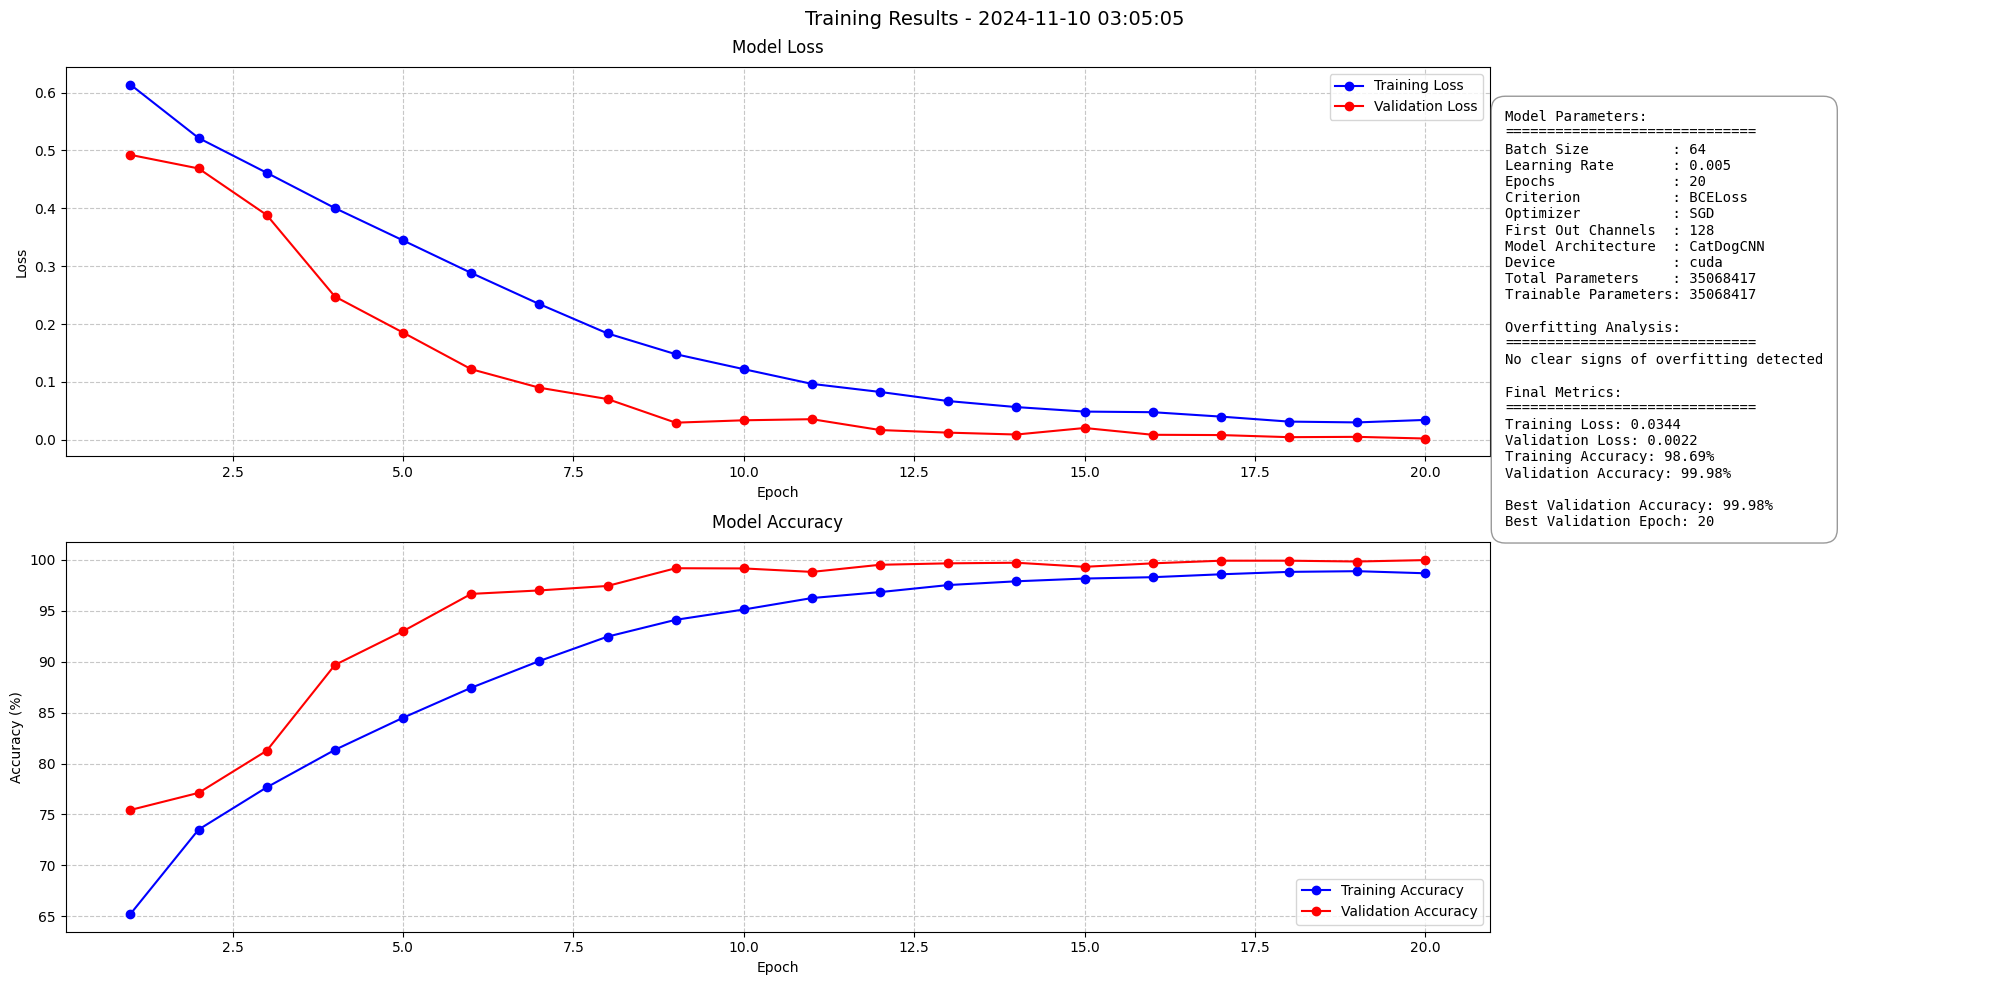

Training with neurons: 128, batch_size: 64, learning_rate: 0.001

Epoch 1/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.85it/s]


Train Loss: 0.6199, Train Acc: 64.14%
Validation Loss: 0.4839, Validation Acc: 77.06%

Epoch 2/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.04it/s]


Train Loss: 0.5379, Train Acc: 72.03%
Validation Loss: 0.4368, Validation Acc: 78.80%

Epoch 3/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 32.19it/s]


Train Loss: 0.4781, Train Acc: 76.49%
Validation Loss: 0.3197, Validation Acc: 86.24%

Epoch 4/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 29.85it/s]


Train Loss: 0.4265, Train Acc: 79.72%
Validation Loss: 0.2549, Validation Acc: 90.36%

Epoch 5/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.80it/s]


Train Loss: 0.3659, Train Acc: 83.19%
Validation Loss: 0.2213, Validation Acc: 91.76%

Epoch 6/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.79it/s]


Train Loss: 0.3112, Train Acc: 86.17%
Validation Loss: 0.1700, Validation Acc: 93.70%

Epoch 7/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 32.11it/s]


Train Loss: 0.2437, Train Acc: 89.69%
Validation Loss: 0.1048, Validation Acc: 96.32%

Epoch 8/20


Validation: 100%|██████████| 79/79 [00:04<00:00, 17.62it/s]


Train Loss: 0.1993, Train Acc: 92.00%
Validation Loss: 0.0784, Validation Acc: 97.50%

Epoch 9/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.99it/s]


Train Loss: 0.1599, Train Acc: 93.76%
Validation Loss: 0.0537, Validation Acc: 98.40%

Epoch 10/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.42it/s]


Train Loss: 0.1311, Train Acc: 94.95%
Validation Loss: 0.0326, Validation Acc: 99.06%

Epoch 11/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.09it/s]


Train Loss: 0.1085, Train Acc: 95.87%
Validation Loss: 0.0490, Validation Acc: 98.20%

Epoch 12/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.90it/s]


Train Loss: 0.0924, Train Acc: 96.62%
Validation Loss: 0.0384, Validation Acc: 98.64%

Epoch 13/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.07it/s]


Train Loss: 0.0758, Train Acc: 97.17%
Validation Loss: 0.0159, Validation Acc: 99.54%

Epoch 14/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.10it/s]


Train Loss: 0.0719, Train Acc: 97.40%
Validation Loss: 0.0134, Validation Acc: 99.74%

Epoch 15/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.18it/s]


Train Loss: 0.0581, Train Acc: 97.91%
Validation Loss: 0.0089, Validation Acc: 99.82%

Epoch 16/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.04it/s]


Train Loss: 0.0516, Train Acc: 98.20%
Validation Loss: 0.0185, Validation Acc: 99.40%

Epoch 17/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.51it/s]


Train Loss: 0.0469, Train Acc: 98.27%
Validation Loss: 0.0067, Validation Acc: 99.82%

Epoch 18/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.90it/s]


Train Loss: 0.0411, Train Acc: 98.58%
Validation Loss: 0.0130, Validation Acc: 99.56%

Epoch 19/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.95it/s]


Train Loss: 0.0348, Train Acc: 98.78%
Validation Loss: 0.0076, Validation Acc: 99.74%

Epoch 20/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.06it/s]


Train Loss: 0.0362, Train Acc: 98.69%
Validation Loss: 0.0045, Validation Acc: 99.92%


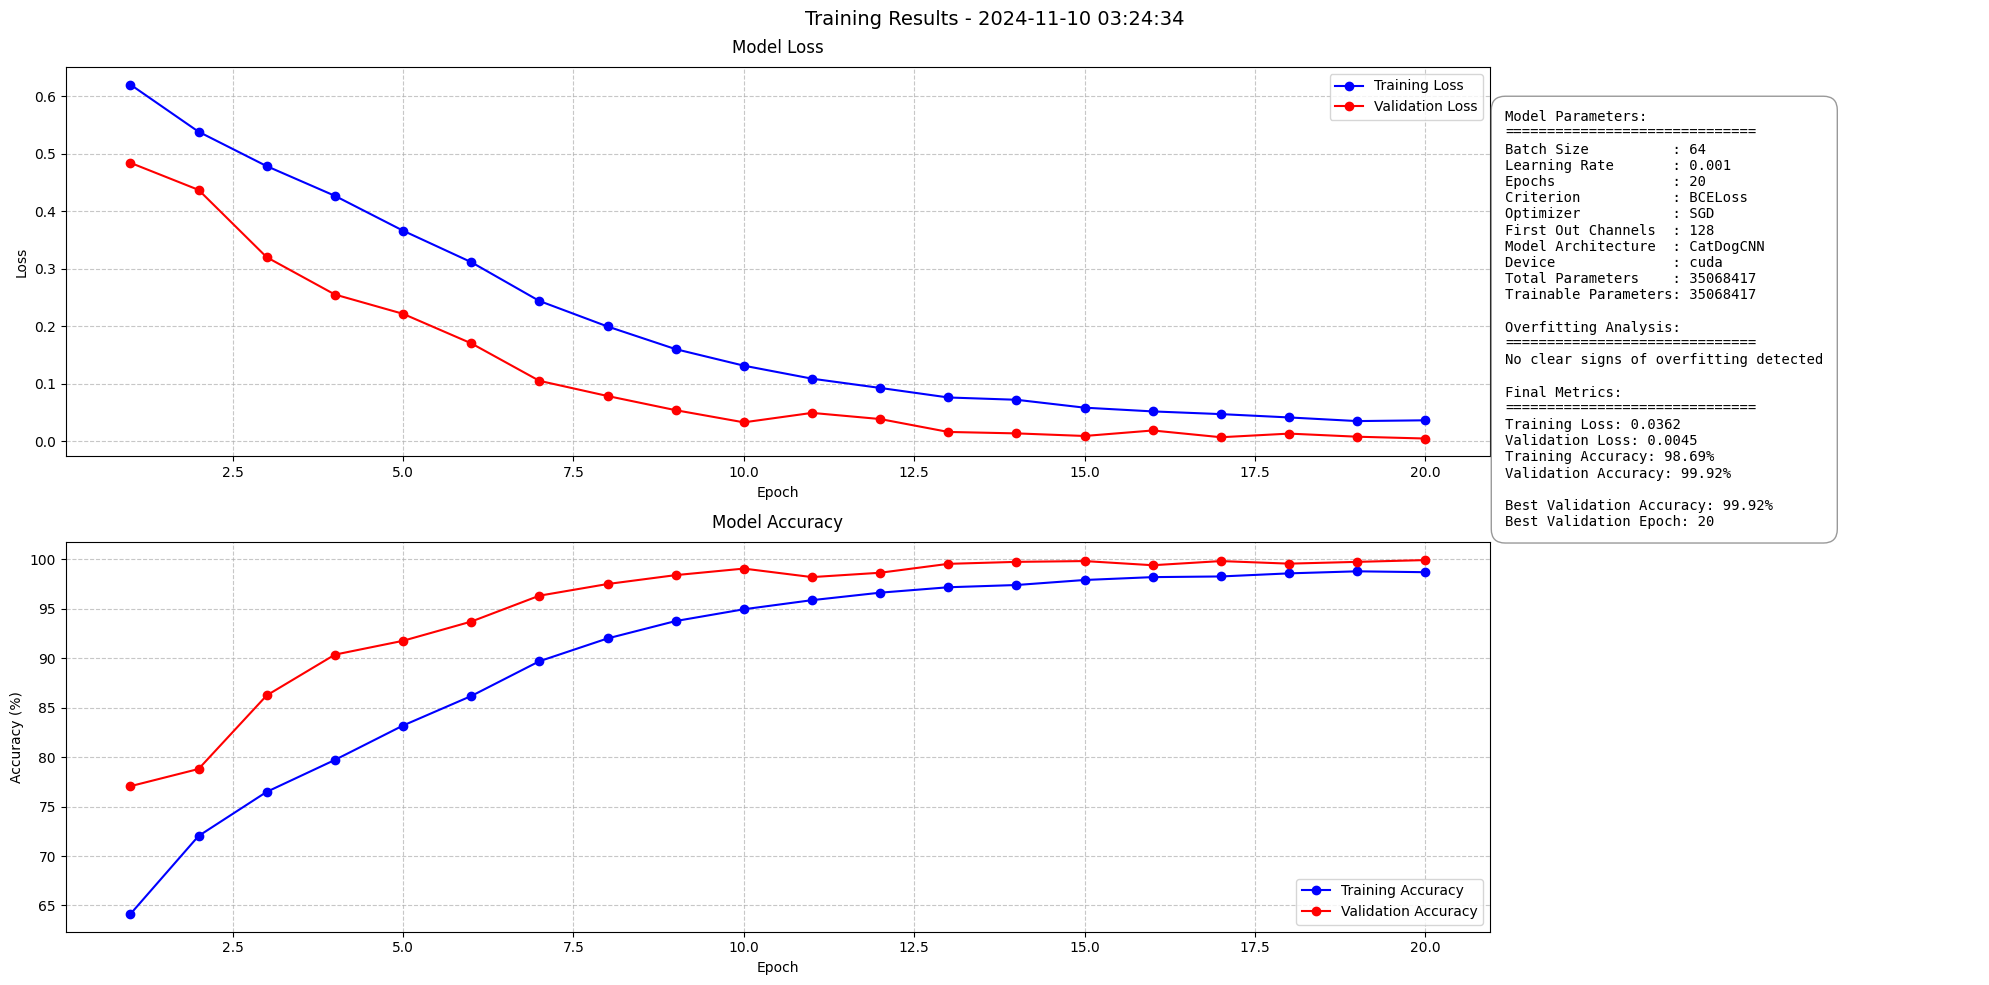

Training with neurons: 128, batch_size: 64, learning_rate: 0.0005

Epoch 1/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.22it/s]


Train Loss: 0.6296, Train Acc: 63.28%
Validation Loss: 0.4945, Validation Acc: 75.92%

Epoch 2/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.03it/s]


Train Loss: 0.5511, Train Acc: 70.92%
Validation Loss: 0.4169, Validation Acc: 81.14%

Epoch 3/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.00it/s]


Train Loss: 0.5015, Train Acc: 74.71%
Validation Loss: 0.3789, Validation Acc: 83.66%

Epoch 4/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.82it/s]


Train Loss: 0.4461, Train Acc: 78.77%
Validation Loss: 0.3085, Validation Acc: 86.76%

Epoch 5/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.32it/s]


Train Loss: 0.3925, Train Acc: 81.75%
Validation Loss: 0.2345, Validation Acc: 90.62%

Epoch 6/20


Validation: 100%|██████████| 79/79 [00:04<00:00, 18.14it/s]


Train Loss: 0.3380, Train Acc: 84.90%
Validation Loss: 0.3978, Validation Acc: 82.04%

Epoch 7/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.57it/s]


Train Loss: 0.2736, Train Acc: 88.31%
Validation Loss: 0.1295, Validation Acc: 95.22%

Epoch 8/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.62it/s]


Train Loss: 0.2177, Train Acc: 91.02%
Validation Loss: 0.0814, Validation Acc: 97.76%

Epoch 9/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.91it/s]


Train Loss: 0.1717, Train Acc: 93.25%
Validation Loss: 0.1001, Validation Acc: 96.24%

Epoch 10/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.75it/s]


Train Loss: 0.1342, Train Acc: 94.70%
Validation Loss: 0.0576, Validation Acc: 98.06%

Epoch 11/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.62it/s]


Train Loss: 0.1165, Train Acc: 95.52%
Validation Loss: 0.0274, Validation Acc: 99.46%

Epoch 12/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 32.53it/s]


Train Loss: 0.0910, Train Acc: 96.61%
Validation Loss: 0.0392, Validation Acc: 98.68%

Epoch 13/20


Validation: 100%|██████████| 79/79 [00:04<00:00, 18.19it/s]


Train Loss: 0.0892, Train Acc: 96.75%
Validation Loss: 0.0254, Validation Acc: 99.24%

Epoch 14/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.07it/s]


Train Loss: 0.0719, Train Acc: 97.42%
Validation Loss: 0.0137, Validation Acc: 99.62%

Epoch 15/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.96it/s]


Train Loss: 0.0635, Train Acc: 97.68%
Validation Loss: 0.0170, Validation Acc: 99.60%

Epoch 16/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.19it/s]


Train Loss: 0.0526, Train Acc: 98.14%
Validation Loss: 0.0080, Validation Acc: 99.86%

Epoch 17/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.31it/s]


Train Loss: 0.0470, Train Acc: 98.34%
Validation Loss: 0.0096, Validation Acc: 99.84%

Epoch 18/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.27it/s]


Train Loss: 0.0436, Train Acc: 98.40%
Validation Loss: 0.0307, Validation Acc: 99.04%

Epoch 19/20


Validation: 100%|██████████| 79/79 [00:02<00:00, 31.13it/s]


Train Loss: 0.0422, Train Acc: 98.53%
Validation Loss: 0.0064, Validation Acc: 99.88%

Epoch 20/20


Validation: 100%|██████████| 79/79 [00:04<00:00, 18.11it/s]


Train Loss: 0.0370, Train Acc: 98.69%
Validation Loss: 0.0100, Validation Acc: 99.72%


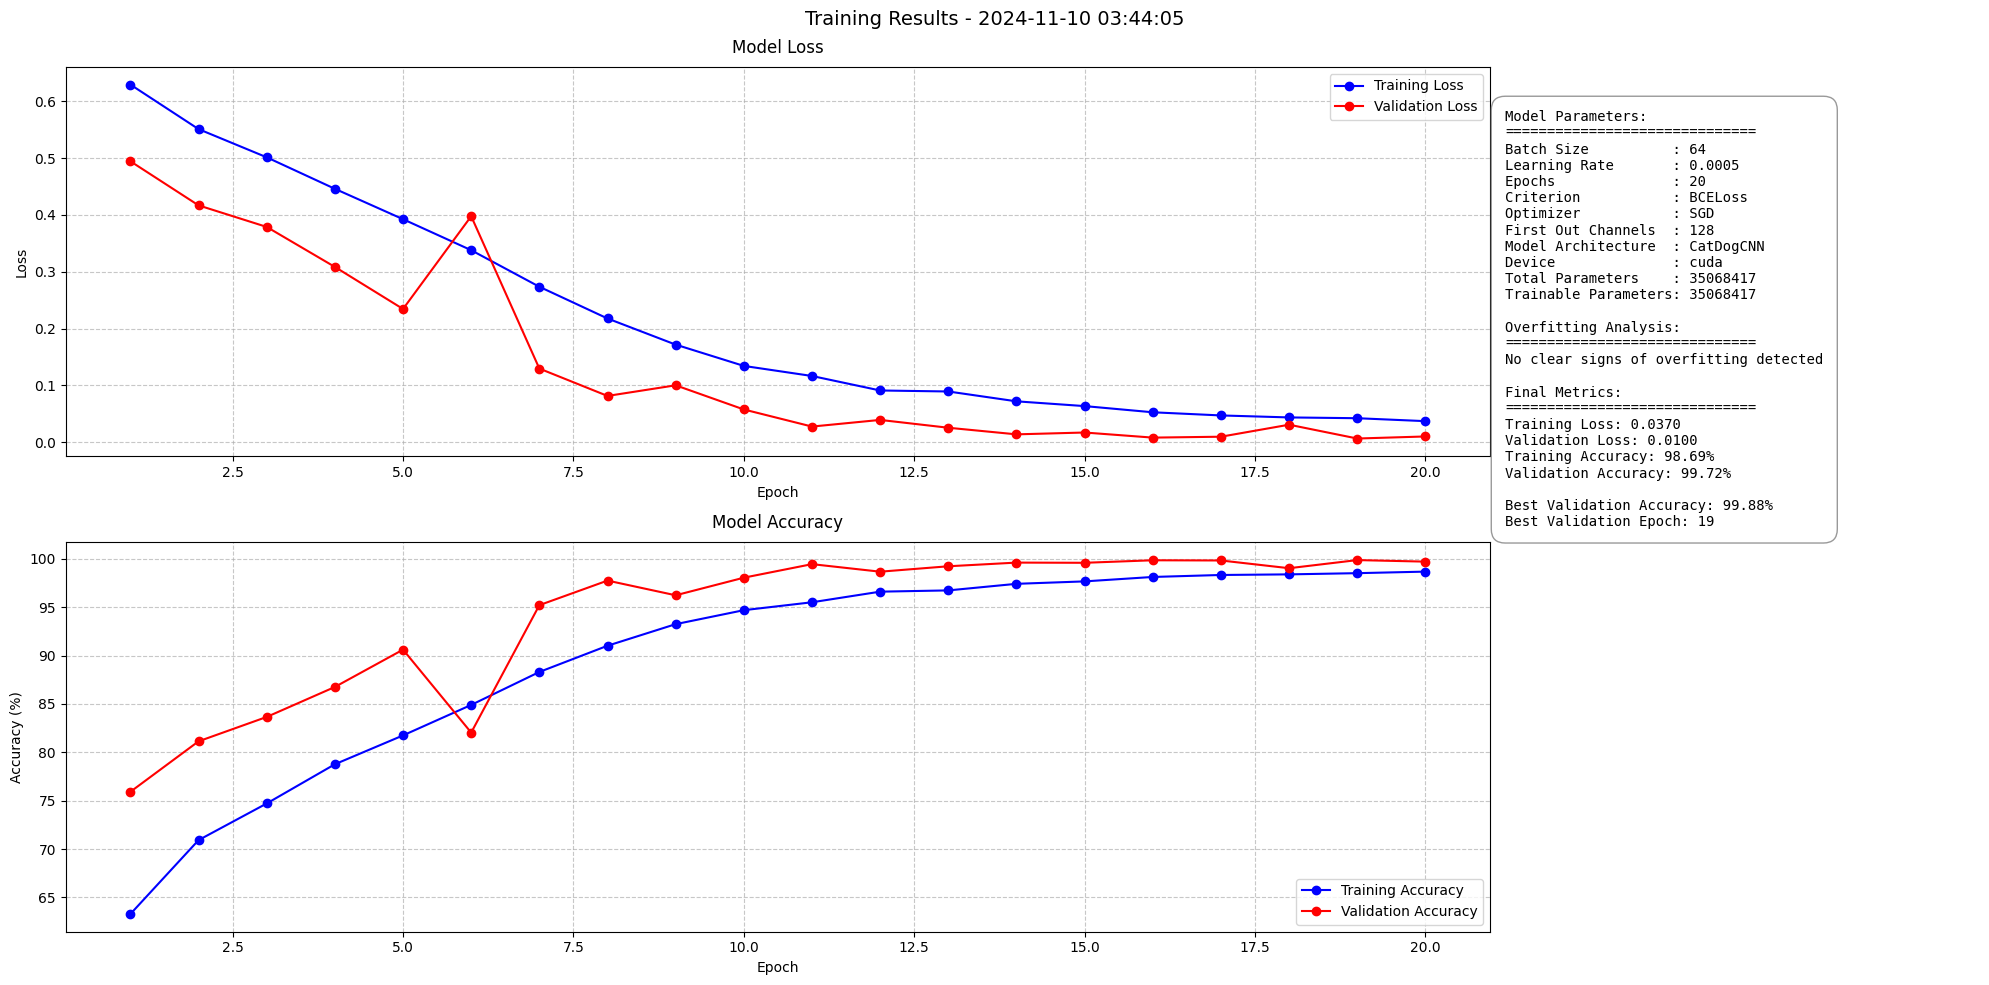

In [7]:
neurons = [32, 64, 128]
batch_sizes = [32, 64]
learning_rates = [0.005, 0.001, 0.0005]

for neuron in neurons:
        for batch_size in batch_sizes:
            for lr in learning_rates:
                print(f'Training with neurons: {neuron}, batch_size: {batch_size}, learning_rate: {lr}')
                
                model = CatDogCNN(neuron).to(device)
                criterion = nn.BCELoss()
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
                
                train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
                val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

                train_model(
                    model=model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    criterion=criterion,
                    optimizer=optimizer,
                    num_epochs=20,
                    device=device
                )

After Doing grid search with SGD Optimaziatiomn

We decided that the best parameter is
lr = 0.005
batch size = 32
second neuron = 32

If using adam optimaziation function change learning rate into 0.001 (which produce the same overall result)

Train the model for around 15-30 epochs (usually the peak accuracy is around 20-25)

Please look at model.py to reproduce the same result 1 more time